<center>
    <h1><b><font color="blue"> Notebook 6 - Séries temporelles</font> </b></h1>
</center>

<b>Objectif du Notebook :</b>
<p>Prédire les séries temporelles de trois variables : 
    <ul>
        <li> l'humidité de l'air à 15h : Humidity3pm </li> 
        <li> la température maximale de la journée : MaxTemp </li>
        <li> les précipitations : Rainfall </li>
    </ul>
</p>
<b>Plan du Notebook :</b>
<ol>
    <li>Étude des trois variables sur deux villes au climat opposé : Canberra et Cairns</li>
    <li>Étude de Rainfall pour deux climats aux saisons humides opposées : climat tropical et climat méditerranéen</li>
</ol>

<hr>
<h1> Importation des librairies et fonctions </h1>
<hr>

In [75]:
import time 
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

#!pip install pmdarima
from pmdarima.arima import auto_arima

#!pip install prophet
from prophet import Prophet
from pandas import to_datetime
from pandas import DataFrame

from sklearn.metrics import mean_squared_error, mean_absolute_error


from joblib import dump, load

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Autorise l'affichage de plusieurs sorties à partir d'une
                                                # même cellule (sans utiliser print)

<hr>
<h1> Importation des fichiers de travail </h1>
<hr>

Nous travaillerons ici sur le jeu de données dans lequel les valeurs manquantes ont été imputées. Ceci permet de conserver suffisamment de dates d'observation pour toutes les villes et climats étudiés.

In [76]:
# import et visualisation du jeu de données
df = pd.read_csv("weatherAUS_imputer.csv",index_col="Date")
df.index = pd.to_datetime(df.index) 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145455 entries, 2008-07-03 to 2017-06-22
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          145455 non-null  int64  
 1   MinTemp             145455 non-null  float64
 2   MaxTemp             145455 non-null  float64
 3   Rainfall            145455 non-null  float64
 4   Evaporation         145455 non-null  float64
 5   Sunshine            145455 non-null  float64
 6   WindGustSpeed       145455 non-null  float64
 7   WindSpeed9am        145455 non-null  float64
 8   WindSpeed3pm        145455 non-null  float64
 9   Humidity9am         145455 non-null  float64
 10  Humidity3pm         145455 non-null  float64
 11  Pressure9am         145455 non-null  float64
 12  Pressure3pm         145455 non-null  float64
 13  Cloud9am            145455 non-null  int64  
 14  Cloud3pm            145455 non-null  int64  
 15  Temp9am           

Unnamed: 0  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
Date                                                                        
2008-07-03       96322      6.2     15.1       0.0         1.80       2.1   
2008-07-04       96323      5.3     15.9       0.0         1.40       8.0   
2008-07-05       96324      9.8     15.4       0.0         2.80       0.9   
2008-07-06       96325     11.3     15.7       8.1         1.64       1.5   
2008-07-07       96326      7.6     11.2      16.2         4.60       1.1   

            WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  ...  \
Date                                                                ...   
2008-07-03           20.0           2.0          11.0         81.0  ...   
2008-07-04           30.0           6.0          13.0         71.0  ...   
2008-07-05           30.0           9.0           9.0         56.0  ...   
2008-07-06           52.0          15.0          22.0         62.0  ...   
2008-07-07           46.0          17.0          13.0         83.0  ...   

            Rain_J-2  Rain_J+2  Rain_J+3  Mois_cos      Mois_sin  \
Date                                                               
2008-07-03       1.0       0.0       0.0      -1.0  1.224647e-16   
2008-07-04       0.0       0.0       1.0      -1.0  1.224647e-16   
2008-07-05       0.0       1.0       1.0      -1.0  1.224647e-16   
2008-07-06       0.0       1.0       1.0      -1.0  1.224647e-16   
2008-07-07       0.0       1.0       1.0      -1.0  1.224647e-16   

            clim_méditerranéen  clim_océanique  clim_sec  clim_subtropical  \
Date                                                                         
2008-07-03                   1               0         0                 0   
2008-07-04                   1               0         0                 0   
2008-07-05                   1               0         0                 0   
2008-07-06                   1               0         0                 0   
2008-07-07                   1               0         0                 0   

            clim_tropical  
Date                       
2008-07-03              0  
2008-07-04              0  
2008-07-05              0  
2008-07-06              0  
2008-07-07              0  

[5 rows x 46 columns]

In [77]:
#visualisation du nombre d'observations par ville
print("Nombre d'observations par ville :")
df["Location"].value_counts()

Nombre d'observations par ville :


Canberra            3436
Sydney              3344
Melbourne           3193
Perth               3193
Hobart              3193
Brisbane            3193
Darwin              3193
Adelaide            3191
Albany              3040
Launceston          3040
GoldCoast           3040
Townsville          3040
MountGambier        3040
Cairns              3040
Bendigo             3040
Ballarat            3040
Wollongong          3040
AliceSprings        3040
Albury              3040
MountGinini         3040
Tuggeranong         3039
Penrith             3039
Newcastle           3039
Moree               3009
Richmond            3009
Watsonia            3009
Cobar               3009
CoffsHarbour        3009
SydneyAirport       3009
Dartmoor            3009
Mildura             3009
Sale                3009
Portland            3009
PerthAirport        3009
Williamtown         3009
MelbourneAirport    3009
PearceRAAF          3009
Nuriootpa           3009
NorfolkIsland       3009
Witchcliffe         3009


<hr>
<h1> 1 - Études des séries temporelles sur les villes de Canberra et Cairns </h1>

<p><i> Le rapport de modélisation présentera les résultats pour ces deux villes. 

D'autres modèles ont été aussi développés pour quatre autres villes australiennes (Perth,  Adélaïdes, AliceSprings, Norfolkisland), le but étant de couvrir l'ensemble des climats présents en Australie.
    
Ces résultats ne sont pas présentés ici dans un soucis d'alléger le notebook. Vous trouverez dans le rapport d'évaluation les graphiques de saisonnalité des trois variables étudiées pour l'ensemble de ces villes.
    </i></p>
<hr>

In [381]:
ListeVilles = ["Canberra", "Cairns"]
print("Nombre d'observations pour chaque ville et classe climatique de Koppen :")
df[["Location", "Climat_Koppen"]][(df.Location == "Canberra") | (df.Location == "Cairns")].value_counts()

Nombre d'observations pour chaque ville et classe climatique de Koppen :


Location  Climat_Koppen
Canberra  Cfb              3436
Cairns    Am               3040
dtype: int64

<hr>
<h2> 1.1 - Étude des séries temporelles appliquées à la variable humidité à 15h (i.e Humidity3pm) </h2>
<hr>

In [79]:
Hum3pm = pd.DataFrame()

for i in ListeVilles:
    Hum3pm_temp = df[df["Location"] == i]
    Hum3pm = pd.concat([Hum3pm, Hum3pm_temp])

Hum3pm.index = pd.to_datetime(Hum3pm.index) 

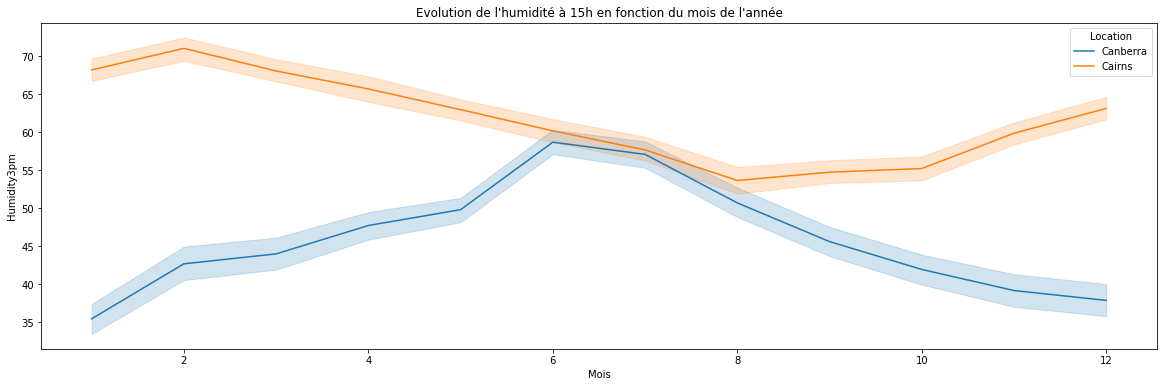

In [80]:
plt.figure(figsize=(20,6))
Graphe =Hum3pm.reset_index()
sns.lineplot(data=Graphe, x="Mois", y="Humidity3pm", hue="Location")
plt.title("Evolution de l'humidité à 15h en fonction du mois de l'année");

Observations :

Cairns, située en climat tropical (classe Am) possède une humidité moyenne plus élevée que celle de Canberra, située en climat océanique (classe Cfb). La saison la plus humide est l'été pour Cairns et l'hiver pour Canberra.
(Pour plus d'explications sur les climats en Australie, se référer à la section 2 du rapport - DataViz)

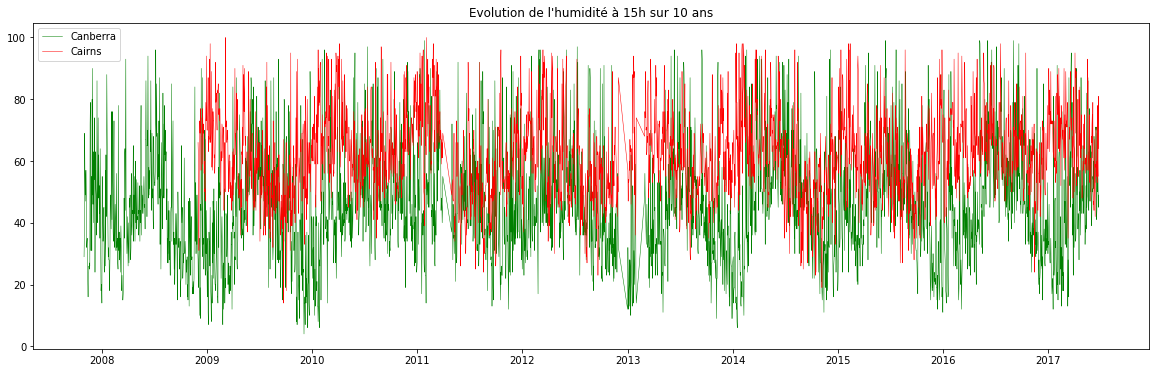

In [81]:
plt.figure(figsize=(20,6))
plt.plot(Hum3pm[Hum3pm["Location"] == "Canberra"]["Humidity3pm"],linewidth=0.5,color='green',label='Canberra')
plt.plot(Hum3pm[Hum3pm["Location"] == "Cairns"]["Humidity3pm"],linewidth=0.5,color='red',label='Cairns')

plt.legend()
plt.title("Evolution de l'humidité à 15h sur 10 ans");

<hr>
<h3> 1.1.1 Série temporelle - Humidité à 15h - Canberra </h3>
<hr>

In [82]:
Ville = "Canberra"
Indicateur = "Humidity3pm"

PredHum3pm = Hum3pm[Hum3pm["Location"] == Ville][["Location",Indicateur]]

#gestion des valeurs manquantes en prenant moyenne des valeurs manquantes
#https://towardsdatascience.com/how-to-interpolate-time-series-data-in-apache-spark-and-python-pandas-part-1-pandas-cff54d76a2ea
PredHum3pm_interpol = PredHum3pm.groupby('Location').resample('D').mean()
PredHum3pm_interpol[Indicateur] = PredHum3pm_interpol[Indicateur].interpolate()
PredHum3pm_interpol = PredHum3pm_interpol.reset_index()
PredHum3pm_interpol.index = PredHum3pm_interpol["Date"]

#### Séries quotidiennes - remplacement des valeurs des dates manquantes

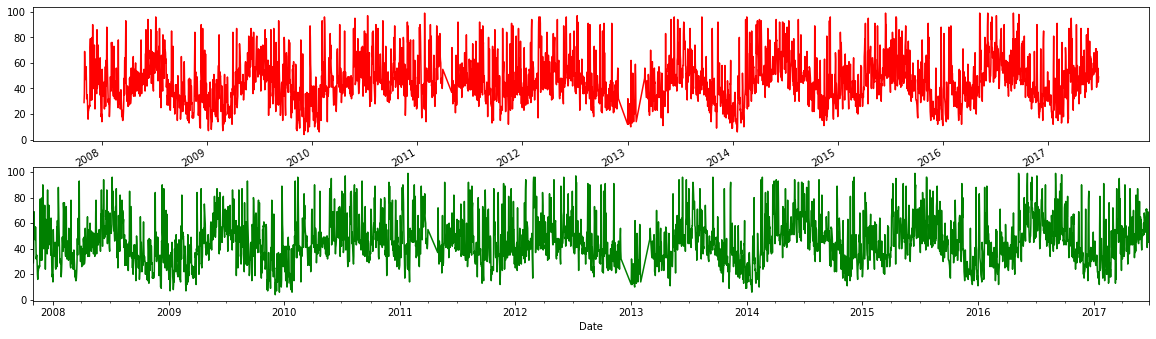

In [83]:
data = PredHum3pm["Humidity3pm"]
data.index = pd.to_datetime(data.index)

data_interpol = PredHum3pm_interpol["Humidity3pm"] 
data_interpol.index = pd.to_datetime(data_interpol.index)

plt.figure(figsize=(20,6));
plt.subplot(211);
data.plot(color="red");
plt.subplot(212);
data_interpol.plot(color="green");

In [84]:
data_interpol = data_interpol.resample('D').mean()

#### Séries mensuelles - remplacement des valeurs des dates manquantes

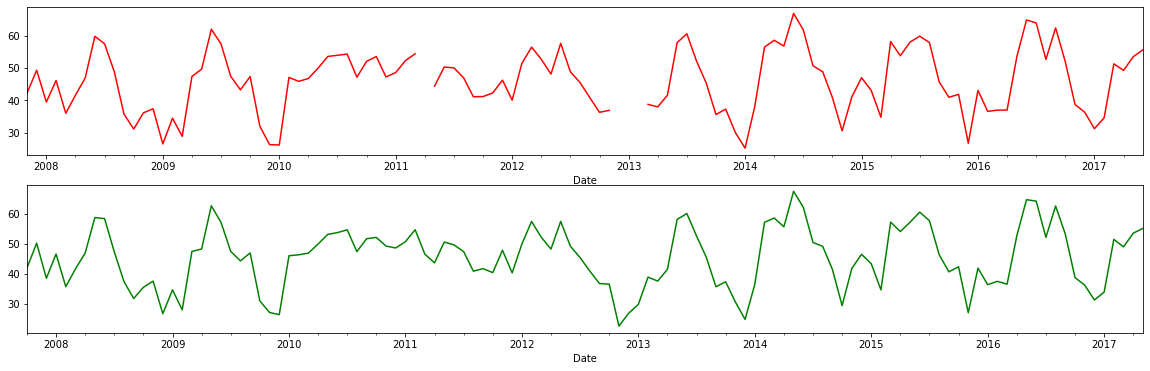

In [85]:
data_mois = data.resample('M').mean()
data_mois_interpol = data_interpol.resample('M',label='left',closed='left').mean()

plt.figure(figsize=(20,6));
plt.subplot(211);
data_mois.plot(color="red");
plt.subplot(212);
data_mois_interpol.plot(color="green");

#### Transformée log

In [86]:
datalog = np.log(data)
data_mois_log = np.log(data_mois)

data_interpol_log = np.log(data_interpol)
data_mois_interpol_log = np.log(data_mois_interpol)
data_mois_interpol_log_2  = data_mois_interpol_log.diff(periods=12).dropna()

#### Décomposition de la série temporelle et visualisation de la saisonnalité

seasonal decompose - Canberra - additive


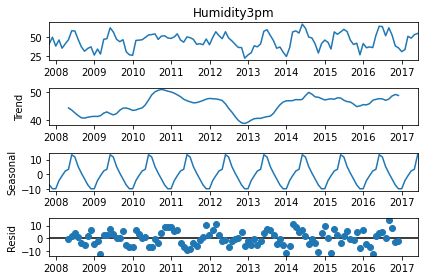

In [87]:
print("seasonal decompose - "+Ville+" - additive")
sd_ad = seasonal_decompose(data_mois_interpol, period=12)
sd_ad.plot()
plt.show();

seasonal decompose - Canberra - multiplicative


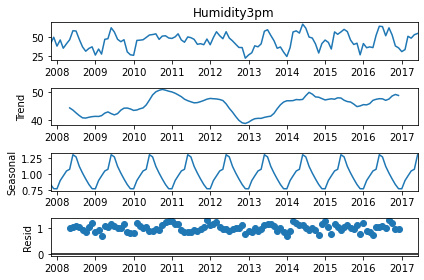

In [88]:
print("seasonal decompose - "+Ville+" - multiplicative")
sd_mu = seasonal_decompose(data_mois_interpol, period=12, model='multiplicative')
sd_mu.plot()
plt.show();

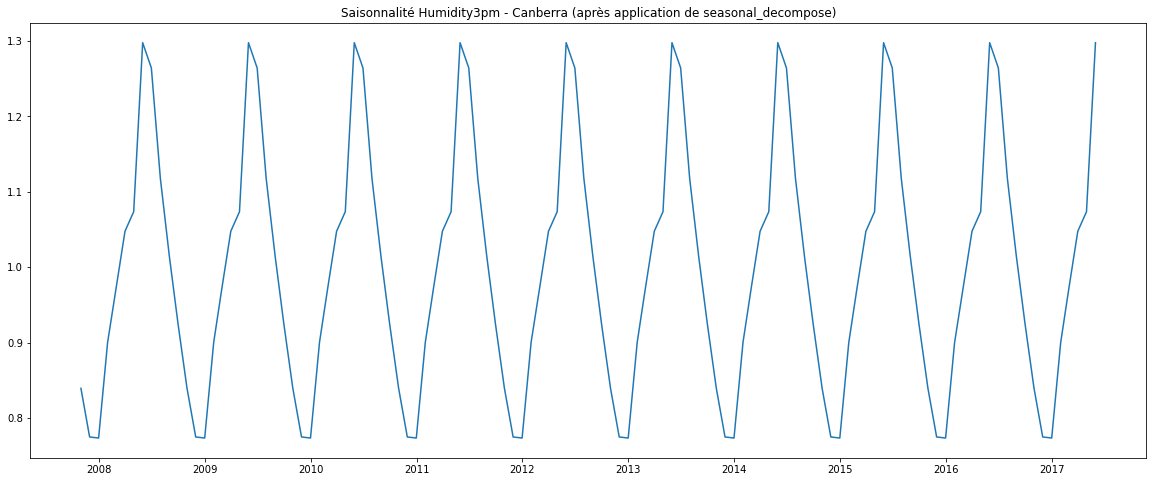

In [89]:
#Visualisation de la saisonnalité de la serie log
plt.figure(figsize=(20,8))
plt.plot(sd_mu.seasonal)
plt.title("Saisonnalité "+Indicateur+" - "+Ville+" (après application de seasonal_decompose)");

#### Autocorrélations

In [90]:
#séries non transformées
data_mois_interpol_1 = data_mois_interpol.diff().dropna()
data_mois_interpol_2 = data_mois_interpol_1.diff(periods = 12).dropna()

#transformées log
data_mois_interpol_log_1 = data_mois_interpol_log.diff().dropna()
data_mois_interpol_log_2 = data_mois_interpol_log_1.diff(periods = 12).dropna()

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


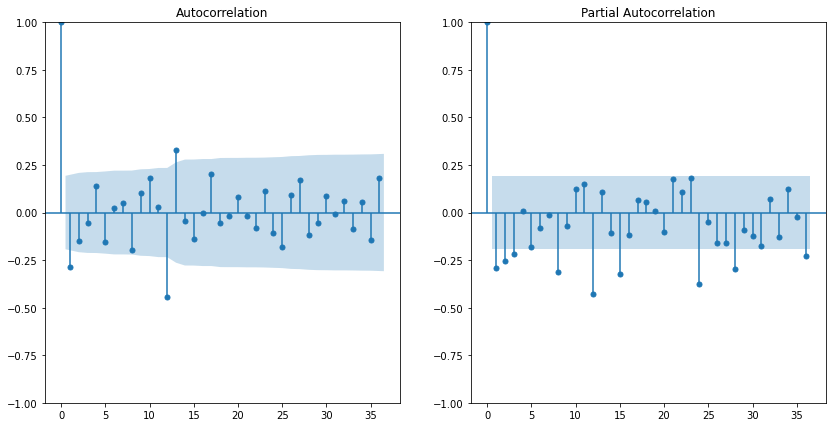

In [91]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plt.figure(figsize= (14,7))
plt.subplot(121)
plot_acf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.subplot(122)
plot_pacf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.show();

#### Modélisation SARIMA


##### Création du modèle et entrainement

In [92]:
#Réduction du jeu de données :
#Les 24 derniers mois sont retirés du jeu d'entrainement afin de servir de test pour évaluer le modèle.
#Les modèles seront entrainés sur la transformée Log

data_mois_interpol_red = data_mois_interpol[0:len(data_mois_interpol)-24]
data_mois_interpol_log_red = data_mois_interpol_log[0:len(data_mois_interpol_log)-24]
data_mois_interpol_log_2_red = data_mois_interpol_log_2[0:len(data_mois_interpol_log_2)-24]

In [93]:
#Recherche des meilleurs paramètres avec auto-arima
step_wise=auto_arima(data_mois_interpol_log_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=1,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=1,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=111)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1.587, Time=0.66 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-11.538, Time=0.92 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1.446, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-16.916, Time=0.65 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-16.255, Time=0.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.33 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-15.849, Time=0.34 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-18.225, Time=0.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-12.938, Time=0.14 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-18.173, Time=0.77 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.

In [94]:
sarima=sm.tsa.SARIMAX(data_mois_interpol_log_red,order=(3,1,0),seasonal_order=(3,1,0,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Humidity3pm   No. Observations:                   92
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                  17.577
Date:                            Thu, 26 May 2022   AIC                            -21.154
Time:                                    16:34:01   BIC                             -4.568
Sample:                                10-31-2007   HQIC                           -14.509
                                     - 05-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3570      0.108     -3.293      0.001      -0.570      -0.145
ar.L2         -0.3290      0.114   

##### Prédictions

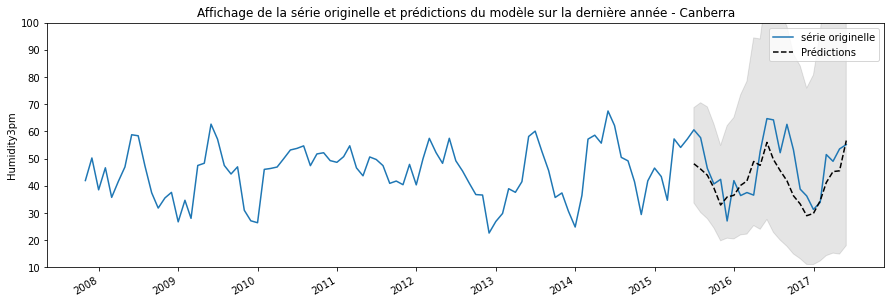

In [95]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
prediction = np.exp(prediction)


fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(10,100)
prediction['mean'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend();

##### Évaluation du modèle

In [96]:
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  9.185
NRMSE_min_max :  0.244
NRMSE_moy :  0.196
MAE erreur absolue moyenne :  7.625  +/-  5.231573035437682
MAPE % erreur absolue moyen :  15.918  %
WMAPE :  16.251  %


In [97]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.00000      0.69988
prédictions  0.69988      1.00000

##### Prédictions future sur trois ans

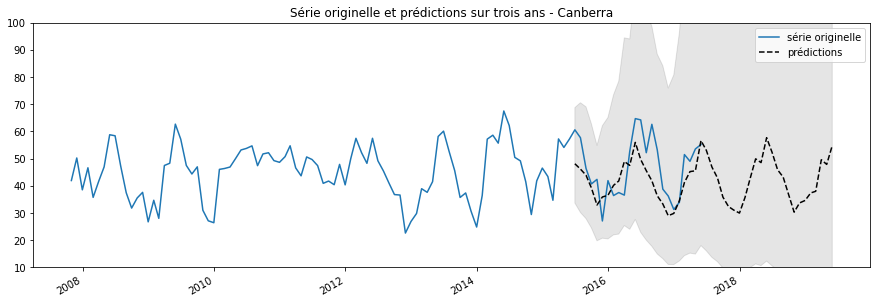

In [98]:
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance
plt.legend()
plt.ylim(10,100)
plt.title("Série originelle et prédictions sur trois ans - "+Ville);

#### Modélisation Prophet

##### https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [99]:
df_prophet=pd.DataFrame({'ds':data_mois_interpol_red.index,'y':data_mois_interpol_red})
df_prophet.info()

# definition du modèle
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_prophet) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2007-10-31 to 2015-05-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      92 non-null     datetime64[ns]
 1   y       92 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


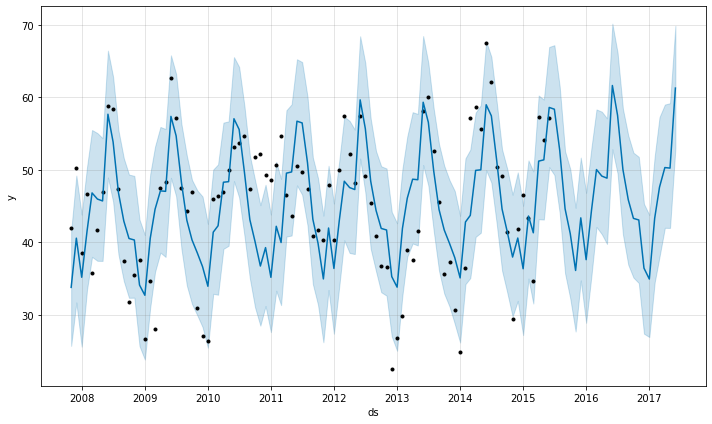

In [100]:
future = model.make_future_dataframe(periods=24,freq = 'M')
#future.head()

forecast = model.predict(future)
forecast.index = forecast["ds"]
forecast.index = pd.to_datetime(forecast.index)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast)


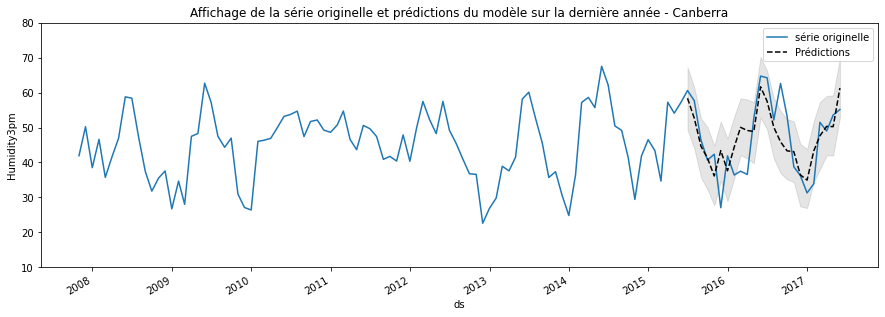

In [101]:
predictions = forecast.tail(24)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(10,80)
predictions['yhat'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(predictions.index, predictions['yhat_lower'], predictions['yhat_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend();

In [102]:
dfcomp = forecast.tail(24)
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'yhat':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  7.561
NRMSE_min_max :  0.201
NRMSE_moy :  0.161
MAE erreur absolue moyenne :  5.996  +/-  4.704845636325895
MAPE % erreur absolue moyen :  14.281  %
WMAPE :  12.779  %


In [103]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.00000      0.71252
prédictions  0.71252      1.00000

<hr>
<h3> 1.1.2 Série temporelle - Humidité à 15h - Cairns </h3>
<hr>

In [104]:
Ville = "Cairns"
Indicateur = "Humidity3pm"

PredHum3pm = Hum3pm[Hum3pm["Location"] == Ville][["Location",Indicateur]]

#gestion des valeurs manquantes en prenant moyenne des valeurs manquantes
#https://towardsdatascience.com/how-to-interpolate-time-series-data-in-apache-spark-and-python-pandas-part-1-pandas-cff54d76a2ea
PredHum3pm_interpol = PredHum3pm.groupby('Location').resample('D').mean()
PredHum3pm_interpol[Indicateur] = PredHum3pm_interpol[Indicateur].interpolate()
PredHum3pm_interpol = PredHum3pm_interpol.reset_index()
PredHum3pm_interpol.index = PredHum3pm_interpol["Date"]


#### Séries quotidiennes - remplacement des valeurs des dates manquantes

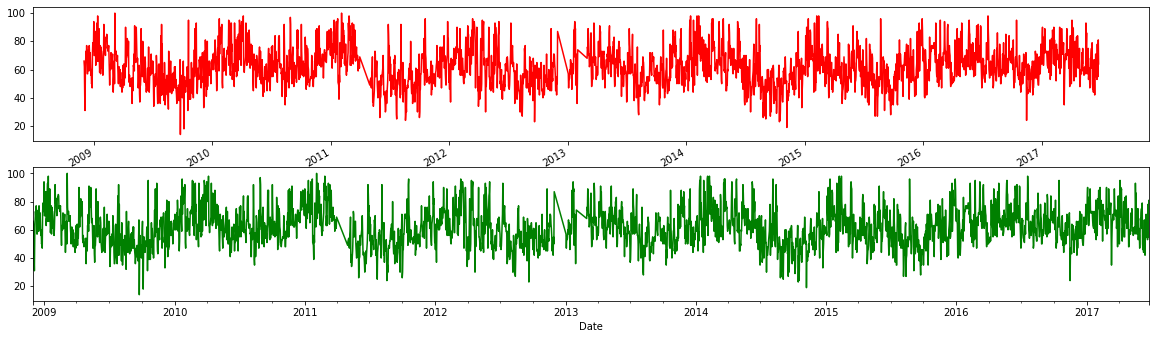

In [105]:
data = PredHum3pm["Humidity3pm"]
data.index = pd.to_datetime(data.index)

data_interpol = PredHum3pm_interpol["Humidity3pm"] 
data_interpol.index = pd.to_datetime(data_interpol.index)

plt.figure(figsize=(20,6));
plt.subplot(211);
data.plot(color="red");
plt.subplot(212);
data_interpol.plot(color="green");

In [106]:
data_interpol = data_interpol.resample('D').mean()

#### Séries mensuelles - remplacement des valeurs des dates manquantes

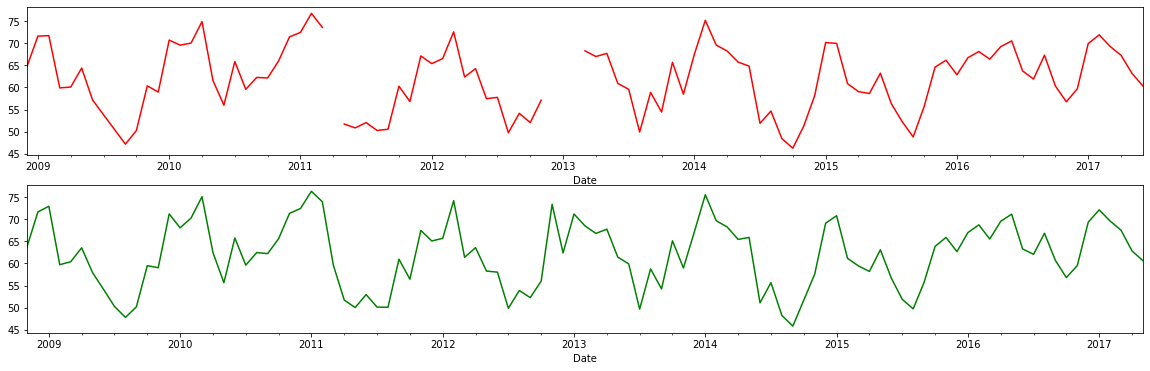

In [107]:
data_mois = data.resample('M').mean()
data_mois_interpol = data_interpol.resample('M',label='left',closed='left').mean()

plt.figure(figsize=(20,6));
plt.subplot(211);
data_mois.plot(color="red");
plt.subplot(212);
data_mois_interpol.plot(color="green");

In [108]:
data_mois_interpol

Date
2008-11-30    63.733333
2008-12-31    71.677419
2009-01-31    72.964286
2009-02-28    59.709677
2009-03-31    60.400000
                ...    
2017-01-31    72.142857
2017-02-28    69.612903
2017-03-31    67.533333
2017-04-30    62.838710
2017-05-31    60.615385
Freq: M, Name: Humidity3pm, Length: 103, dtype: float64

#### Transformée log

In [109]:
datalog = np.log(data)
data_mois_log = np.log(data_mois)

data_interpol_log = np.log(data_interpol)
data_mois_interpol_log = np.log(data_mois_interpol)

#### Décomposition de la série temporelle et visualisation de la saisonnalité

seasonal decompose - Cairns - additive


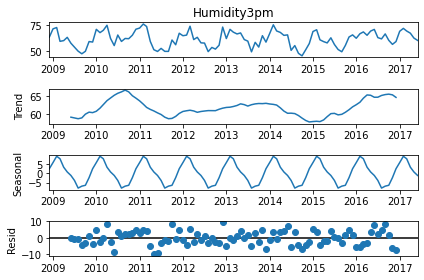

In [110]:
print("seasonal decompose - "+Ville+" - additive")
sd_ad = seasonal_decompose(data_mois_interpol, period=12)
sd_ad.plot()
plt.show();

seasonal decompose - Cairns - multiplicative


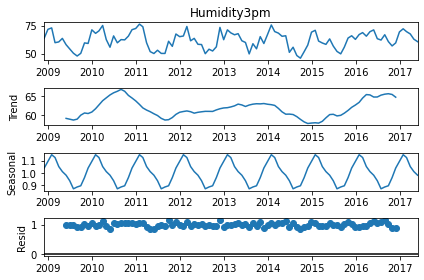

In [111]:
print("seasonal decompose - "+Ville+" - multiplicative")
sd_mu = seasonal_decompose(data_mois_interpol, period=12, model='multiplicative')
sd_mu.plot()
plt.show();

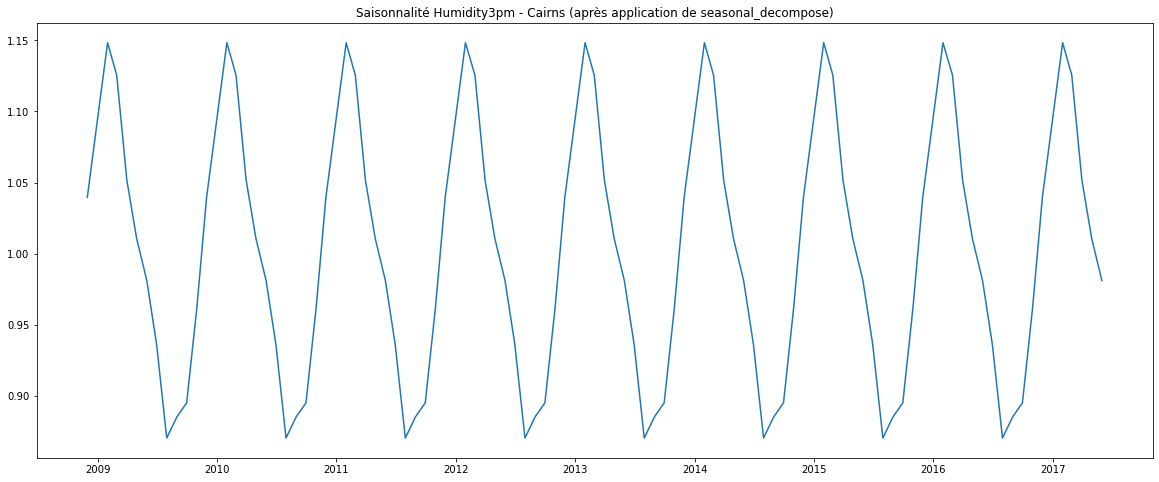

In [112]:
#Visualisation de la saisonnalité de la serie log
plt.figure(figsize=(20,8))
plt.plot(sd_mu.seasonal)
plt.title("Saisonnalité "+Indicateur+" - "+Ville+" (après application de seasonal_decompose)");

#### Autocorrelations

In [113]:
#séries non transformées
data_mois_interpol_1 = data_mois_interpol.diff().dropna()
data_mois_interpol_2 = data_mois_interpol_1.diff(periods = 12).dropna()

#transformées log
data_mois_interpol_log_1 = data_mois_interpol_log.diff().dropna()
data_mois_interpol_log_2 = data_mois_interpol_log_1.diff(periods = 12).dropna()

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


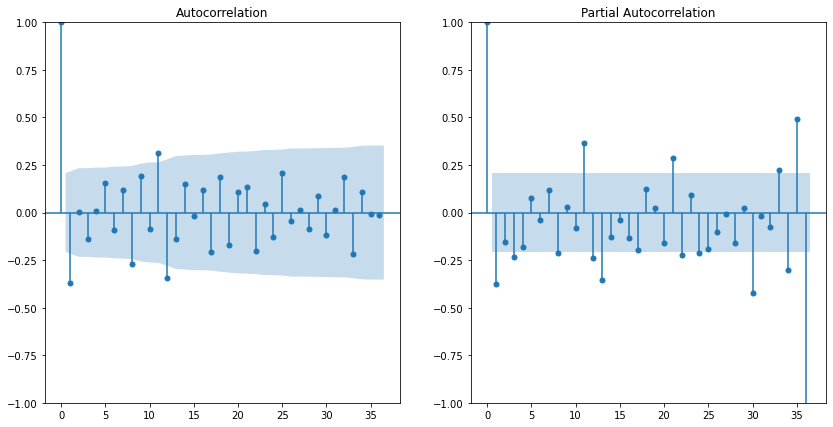

In [114]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plt.figure(figsize= (14,7))
plt.subplot(121)
plot_acf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.subplot(122)
plot_pacf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.show();

#### Modélisation SARIMA


##### Création du modèle et entrainement

In [115]:
# Réduction du jeu de donnée
# Les 24 derniers mois sont retirés du jeu d'entrainement afin de servir de test pour évaluer le modèle

data_mois_interpol_red = data_mois_interpol[0:len(data_mois_interpol)-24]
data_mois_interpol_log_red = data_mois_interpol_log[0:len(data_mois_interpol_log)-24]
data_mois_interpol_log2_red = data_mois_interpol_log_2[0:len(data_mois_interpol_log_2)-24]

In [116]:
#Recherche des meilleurs paramètres avec auto-arima
step_wise=auto_arima(data_mois_interpol_log_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=1,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=1,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=111)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-73.303, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-93.706, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-89.600, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-93.828, Time=0.37 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-94.577, Time=0.71 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-96.130, Time=1.26 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=3.66 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.25 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.69 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=-98.015, Time=3.52 sec
 ARIMA(1,1,0)(6,1,1)[12]             : AIC=-96.014, Time=9.43 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=-96.012, Time=3.50 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=3.15 sec
 ARIMA(1,1,0)(6,1,0)[12]             : AIC=inf, Time=

In [117]:
sarima=sm.tsa.SARIMAX(data_mois_interpol_log_red,order=(0,1,1),seasonal_order=(5,1,0,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Humidity3pm   No. Observations:                   79
Model:             SARIMAX(0, 1, 1)x(5, 1, [], 12)   Log Likelihood                  58.408
Date:                             Thu, 26 May 2022   AIC                           -102.815
Time:                                     16:38:08   BIC                            -87.488
Sample:                                 11-30-2008   HQIC                           -96.759
                                      - 05-31-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6129      0.114     -5.359      0.000      -0.837      -0.389
ar.S.L12      -0.8303      

##### Prédictions

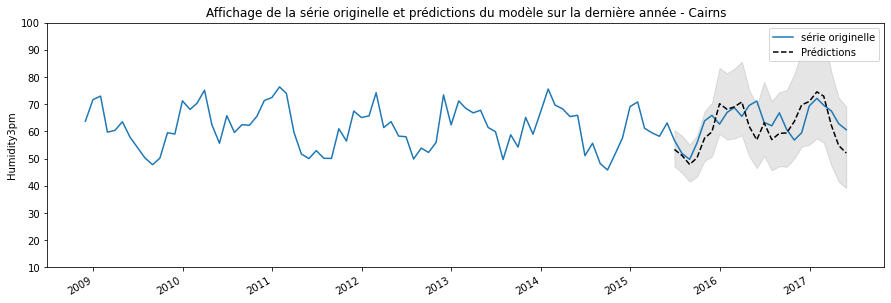

In [118]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
prediction = np.exp(prediction)


fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(10,100)
prediction['mean'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend();

##### Evaluation du modèle

In [119]:
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  6.095
NRMSE_min_max :  0.272
NRMSE_moy :  0.096
MAE erreur absolue moyenne :  5.011  +/-  3.5432767513175105
MAPE % erreur absolue moyen :  7.891  %
WMAPE :  7.914  %


In [120]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.661141
prédictions  0.661141     1.000000

##### Prédictions future sur trois ans

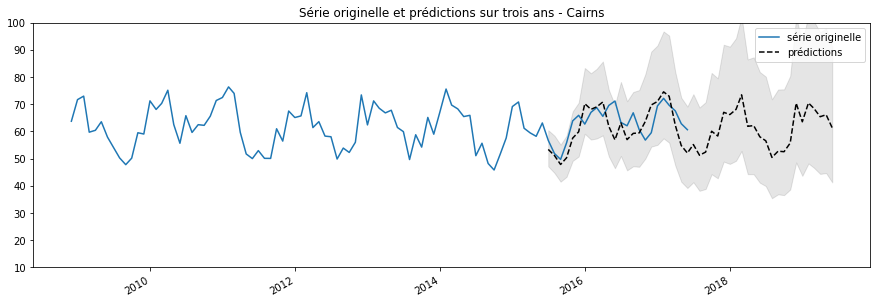

In [121]:
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance
plt.legend()
plt.ylim(10,100)
plt.title("Série originelle et prédictions sur trois ans - "+Ville);

#### Modélisation Prophet 

##### https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [122]:
df_prophet=pd.DataFrame({'ds':data_mois_interpol_red.index,'y':data_mois_interpol_red})
df_prophet.info()

# definition du modèle
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_prophet) 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2008-11-30 to 2015-05-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      79 non-null     datetime64[ns]
 1   y       79 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 KB


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


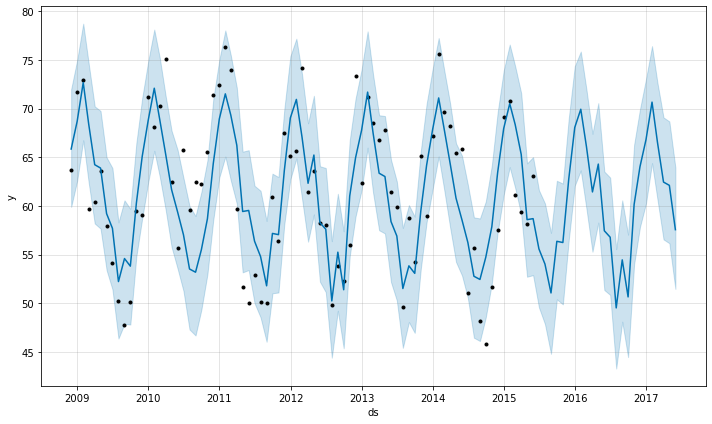

In [123]:
future = model.make_future_dataframe(periods=24,freq = 'M')
#future.head()

forecast = model.predict(future)
forecast.index = forecast["ds"]
forecast.index = pd.to_datetime(forecast.index)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast)


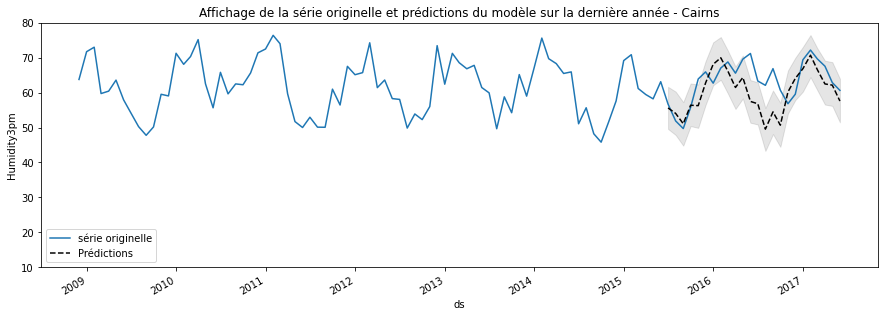

In [124]:
predictions = forecast.tail(24)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(10,80)
predictions['yhat'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(predictions.index, predictions['yhat_lower'], predictions['yhat_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend();

In [125]:
dfcomp = forecast.tail(24)
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'yhat':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  6.093
NRMSE_min_max :  0.272
NRMSE_moy :  0.096
MAE erreur absolue moyenne :  4.802  +/-  3.8314222682542503
MAPE % erreur absolue moyen :  7.473  %
WMAPE :  7.584  %


In [126]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.00000      0.61246
prédictions  0.61246      1.00000

<hr>
<h2> 1.2 - Étude des séries temporelles appliquées à la variable température maximale, i.e. MaxTemp </h2>
<hr>

In [127]:
Temp = pd.DataFrame()

for i in ListeVilles:
    Temp1 = df[df["Location"] == i]
    Temp = pd.concat([Temp,Temp1])

Temp.index = pd.to_datetime(Temp.index) 

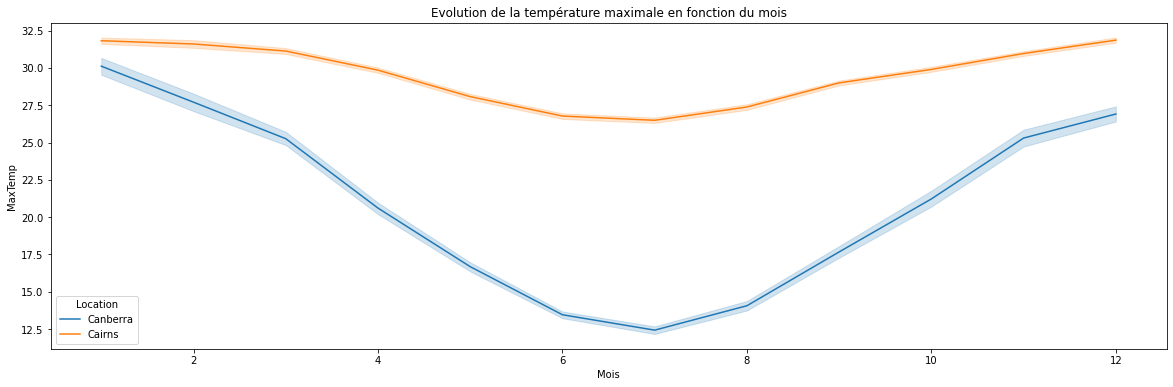

In [128]:
plt.figure(figsize=(20,6))
Graphe =Temp.reset_index()
sns.lineplot(data=Graphe, x="Mois", y="MaxTemp", hue="Location")
plt.title("Evolution de la température maximale en fonction du mois");

Observations :
La chute hivernale des températures est beaucoup plus importante à Canberra (climat océanique) qu'à Cairns (climat tropical), ce qui est cohérent étant donné les latitudes de ces deux villes.

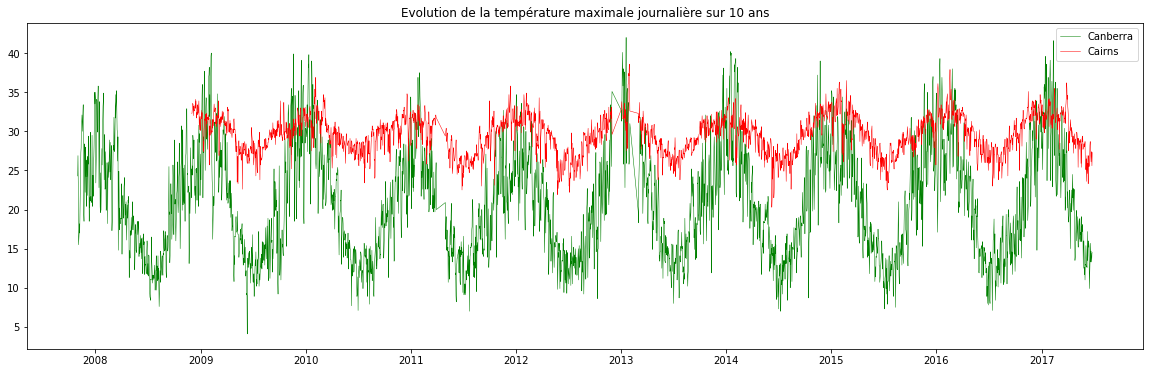

In [129]:
plt.figure(figsize=(20,6))
plt.plot(Temp[Temp["Location"] == "Canberra"]["MaxTemp"],linewidth=0.5,color='green',label='Canberra')
plt.plot(Temp[Temp["Location"] == "Cairns"]["MaxTemp"],linewidth=0.5,color='red',label='Cairns')
plt.legend()
plt.title("Evolution de la température maximale journalière sur 10 ans");

<hr>
<h3> 1.2.1 - Série temporelle - Température Maximale - Canberra </h3>
<hr>

In [130]:
Ville = "Canberra"
Indicateur = "MaxTemp"

PredTemp = Temp[Temp["Location"] == Ville][["Location",Indicateur]]

#gestion des valeurs manquantes en prenant moyenne des valeurs manquantes
#https://towardsdatascience.com/how-to-interpolate-time-series-data-in-apache-spark-and-python-pandas-part-1-pandas-cff54d76a2ea
PredTemp_interpol = PredTemp.groupby('Location').resample('D').mean()
PredTemp_interpol[Indicateur] = PredTemp_interpol[Indicateur].interpolate()
PredTemp_interpol = PredTemp_interpol.reset_index()
PredTemp_interpol.index = PredTemp_interpol["Date"]
#PredTemp_interpol

#### Séries quotidiennes - remplacement des valeurs des dates manquantes

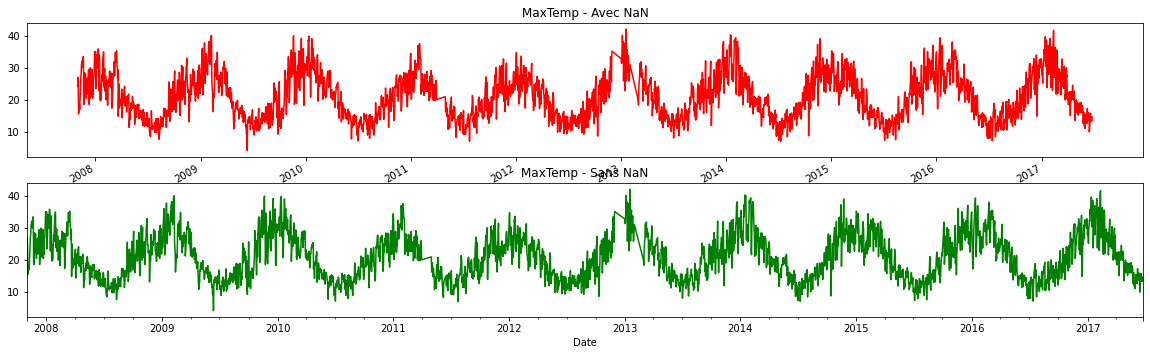

In [131]:
data = PredTemp["MaxTemp"]
data.index = pd.to_datetime(data.index)

data_interpol = PredTemp_interpol["MaxTemp"] 
data_interpol.index = pd.to_datetime(data_interpol.index)

plt.figure(figsize=(20,6));
plt.subplot(211);
data.plot(color="red");
plt.title(Indicateur+" - Avec NaN")
plt.subplot(212);
data_interpol.plot(color="green");
plt.title(Indicateur+" - Sans NaN");

#### Séries mensuelles - remplacement des valeurs des dates manquantes

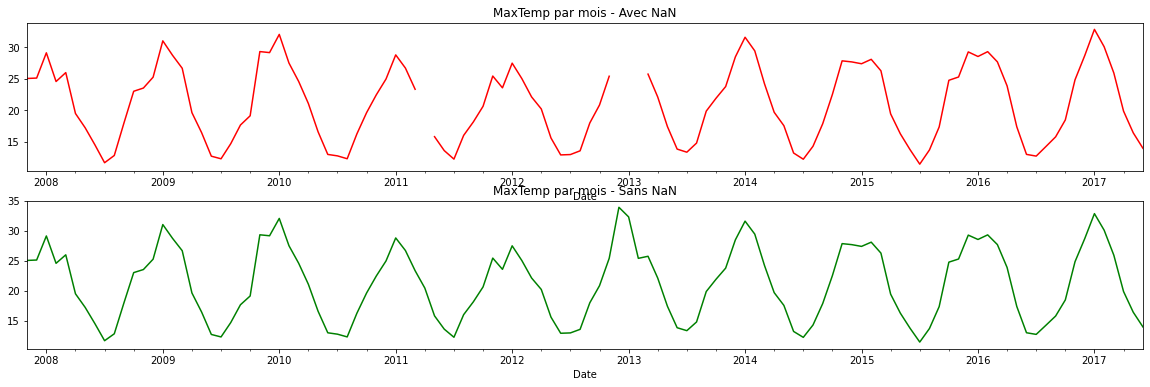

In [132]:
data_mois = data.resample('M').mean()
data_mois_interpol = data_interpol.resample('M').mean()

plt.figure(figsize=(20,6));
plt.subplot(211);
data_mois.plot(color="red");
plt.title(Indicateur+" par mois - Avec NaN")
plt.subplot(212);
data_mois_interpol.plot(color="green")
plt.title(Indicateur+" par mois - Sans NaN");

#### Transformée log

In [133]:
datalog = np.log(data)
data_mois_log = np.log(data_mois)

data_interpol_log = np.log(data_interpol)
data_mois_interpol_log = np.log(data_mois_interpol)

#### Décomposition de la série temporelle et visualisation de la saisonnalité

seasonal decompose - Canberra - additive


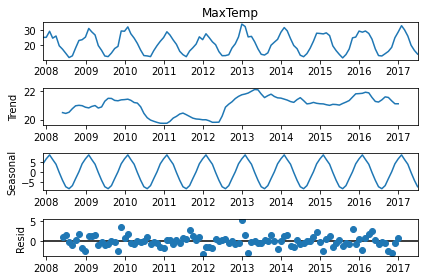

In [134]:
print("seasonal decompose - "+Ville+" - additive")
sd_ad = seasonal_decompose(data_mois_interpol, period=12)
sd_ad.plot()
plt.show();

seasonal decompose - Canberra - multiplicative


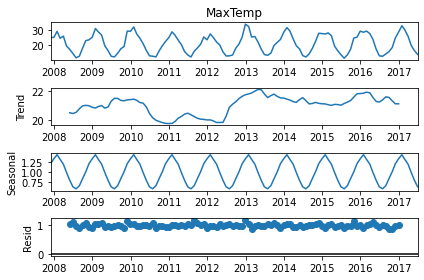

In [135]:
print("seasonal decompose - "+Ville+" - multiplicative")
sd_mu = seasonal_decompose(data_mois_interpol, period=12, model='multiplicative')
sd_mu.plot()
plt.show();

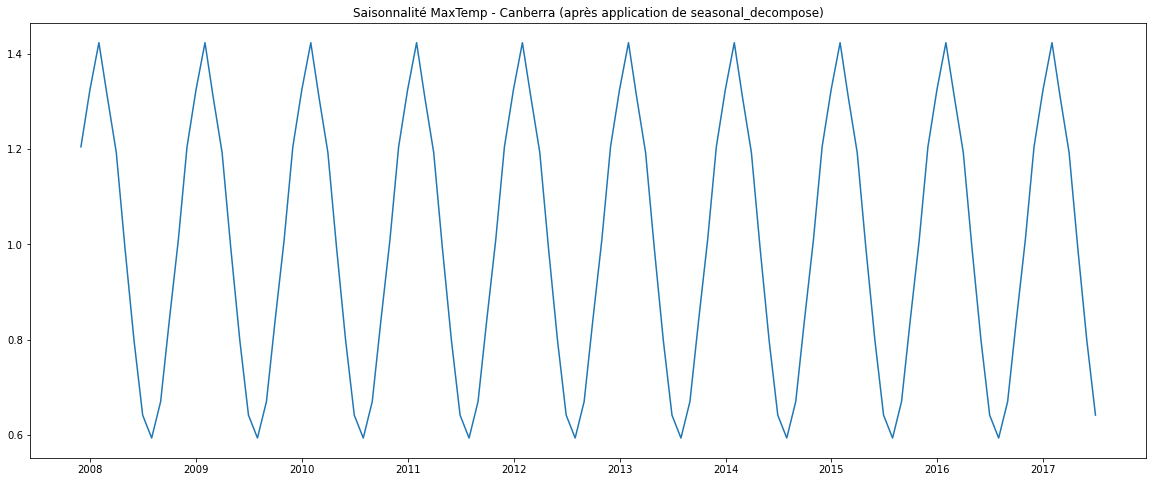

In [136]:
#Visualisation de la saisonnalité de la serie log
plt.figure(figsize=(20,8))
plt.plot(sd_mu.seasonal)
plt.title("Saisonnalité "+Indicateur+" - "+Ville+" (après application de seasonal_decompose)");

#### Autocorrelations

In [137]:
#séries non transformées
data_mois_interpol_1 = data_mois_interpol.diff().dropna()
data_mois_interpol_2 = data_mois_interpol_1.diff(periods = 12).dropna()

#transformées log
data_mois_interpol_log_1 = data_mois_interpol_log.diff().dropna()
data_mois_interpol_log_2 = data_mois_interpol_log_1.diff(periods = 12).dropna()

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


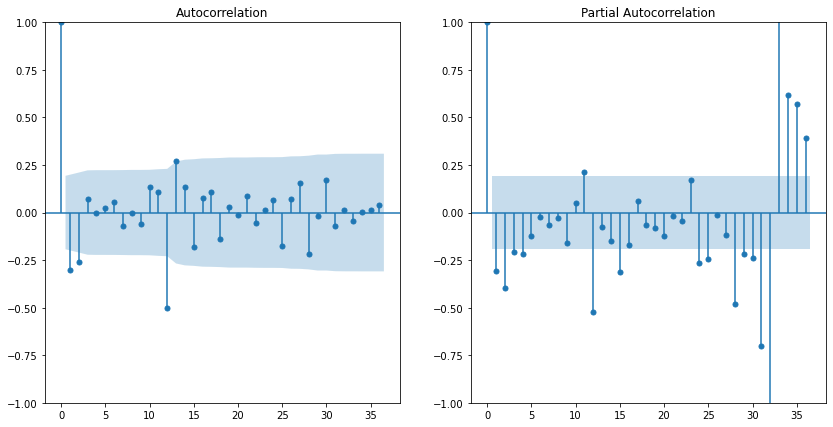

In [138]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plt.figure(figsize= (14,7))
plt.subplot(121)
plot_acf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.subplot(122)
plot_pacf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.show();

#### Modélisation SARIMA

##### Création et entrainement du modèle

In [139]:
# Réduction du jeu de donnée
# Les 24 derniers mois sont retirés du jeu d'entrainement afin de servir de test pour évaluer le modèle
data_mois_interpol_red = data_mois_interpol[0:len(data_mois_interpol)-24]
data_mois_interpol_log_red = data_mois_interpol_log[0:len(data_mois_interpol_log)-24]

In [140]:
#Recherche des meilleurs paramètres avec auto-arima
step_wise=auto_arima(data_mois_interpol_log_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=0, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=0,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=111)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=40.233, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-137.859, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-77.185, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=466.444, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-60.324, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-164.269, Time=0.37 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-91.563, Time=0.17 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-162.569, Time=0.72 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-168.070, Time=0.86 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-114.543, Time=0.60 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,0,0)(1,0,3)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(1,0,0)(0,0,3)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(1,0,0)(2,0,3)[12] intercept   : AIC=in

In [141]:
#Entrainement du modèle Sarima et affichage des tests statistiques
sarima=sm.tsa.SARIMAX(data_mois_interpol_log_red,order=(1,0,0),seasonal_order=(1,0,2,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                        SARIMAX Results                                        
Dep. Variable:                                 MaxTemp   No. Observations:                   92
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood                  75.661
Date:                                 Thu, 26 May 2022   AIC                           -141.322
Time:                                         16:38:54   BIC                           -128.714
Sample:                                     11-30-2007   HQIC                          -136.233
                                          - 06-30-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9785      0.020     48.832      0.000       0.939       1

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [142]:
#Entrainement du modèle Sarima et affichage des tests statistiques
sarima=sm.tsa.SARIMAX(data_mois_interpol_log_red,order=(1,0,0),seasonal_order=(1,0,1,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                      SARIMAX Results                                       
Dep. Variable:                              MaxTemp   No. Observations:                   92
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                  73.120
Date:                              Thu, 26 May 2022   AIC                           -138.241
Time:                                      16:38:55   BIC                           -128.154
Sample:                                  11-30-2007   HQIC                          -134.170
                                       - 06-30-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9961      0.004    227.405      0.000       0.988       1.005
ar.S.L12       0.99

##### Prédictions et évaluations

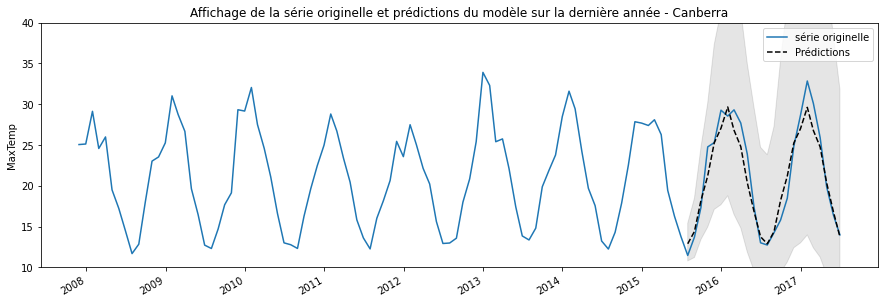

In [143]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(10,40)
prediction['mean'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend();

In [144]:
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  1.925
NRMSE_min_max :  0.09
NRMSE_moy :  0.09
MAE erreur absolue moyenne :  1.512  +/-  1.2169124028328024
MAPE % erreur absolue moyen :  6.742  %
WMAPE :  7.036  %


In [145]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.969845
prédictions  0.969845     1.000000

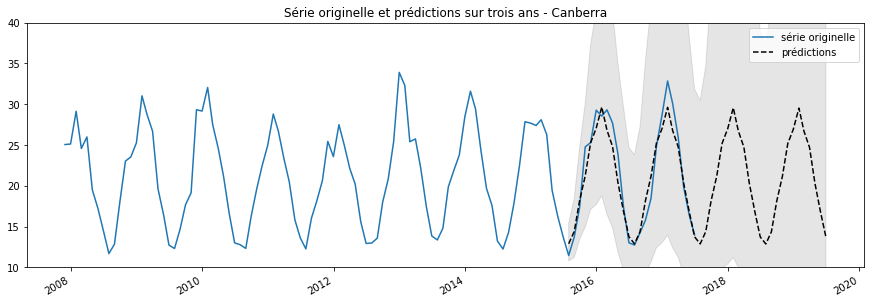

In [146]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance
plt.legend()
plt.ylim(10,40)
plt.title("Série originelle et prédictions sur trois ans - "+Ville);

#### Modélisation Prophet

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [147]:
df_prophet=pd.DataFrame({'ds':data_mois_interpol_red.index,'y':data_mois_interpol_red})
df_prophet.info()

# definition du modèle
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_prophet) 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2007-11-30 to 2015-06-30
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      92 non-null     datetime64[ns]
 1   y       92 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


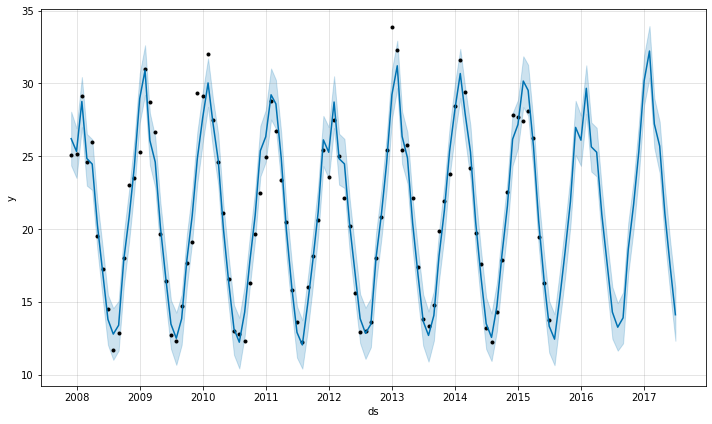

In [148]:
future = model.make_future_dataframe(periods=24,freq = 'M')
#future.head()

forecast = model.predict(future)
forecast.index = forecast["ds"]
forecast.index = pd.to_datetime(forecast.index)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


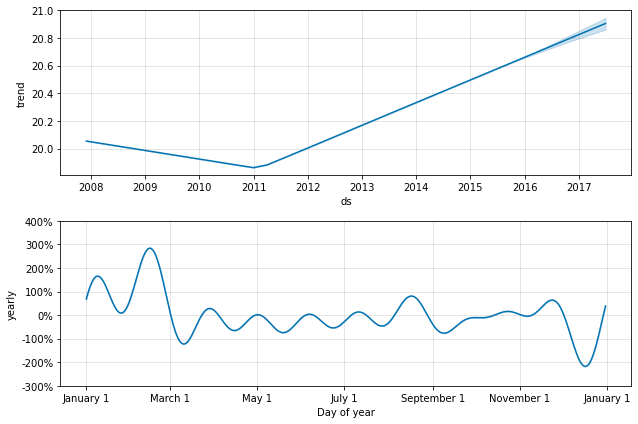

In [149]:
fig = model.plot_components(forecast)

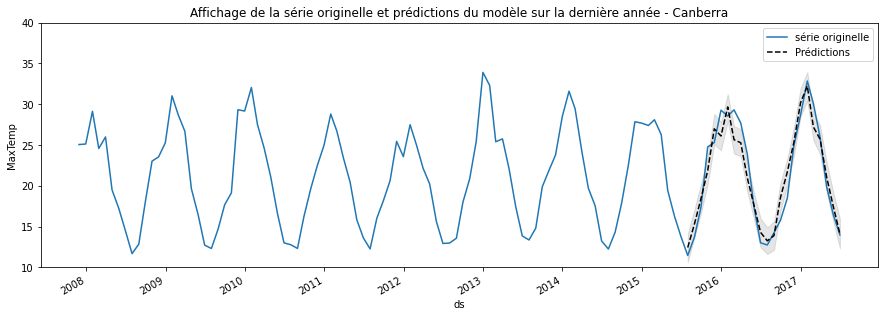

In [150]:
predictions = forecast.tail(24)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(10,40)
predictions['yhat'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(predictions.index, predictions['yhat_lower'], predictions['yhat_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend();

In [151]:
dfcomp = forecast.tail(24)
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'yhat':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  1.922
NRMSE_min_max :  0.09
NRMSE_moy :  0.089
MAE erreur absolue moyenne :  1.576  +/-  1.1234674038490697
MAPE % erreur absolue moyen :  7.406  %
WMAPE :  7.337  %


In [152]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.960295
prédictions  0.960295     1.000000

<hr>
<h3> 1.2.2 - Série temporelle - Température Maximale - Cairns </h3>
<hr>

In [153]:
Ville = "Cairns"
Indicateur = "MaxTemp"

PredTemp = Temp[Temp["Location"] == Ville][["Location",Indicateur]]

#gestion des valeurs manquantes en prenant moyenne des valeurs manquantes
#https://towardsdatascience.com/how-to-interpolate-time-series-data-in-apache-spark-and-python-pandas-part-1-pandas-cff54d76a2ea
PredTemp_interpol = PredTemp.groupby('Location').resample('D').mean()
PredTemp_interpol[Indicateur] = PredTemp_interpol[Indicateur].interpolate()
PredTemp_interpol = PredTemp_interpol.reset_index()
PredTemp_interpol.index = PredTemp_interpol["Date"]
#PredTemp_interpol

#### Séries quotidiennes - remplacement des valeurs des dates manquantes

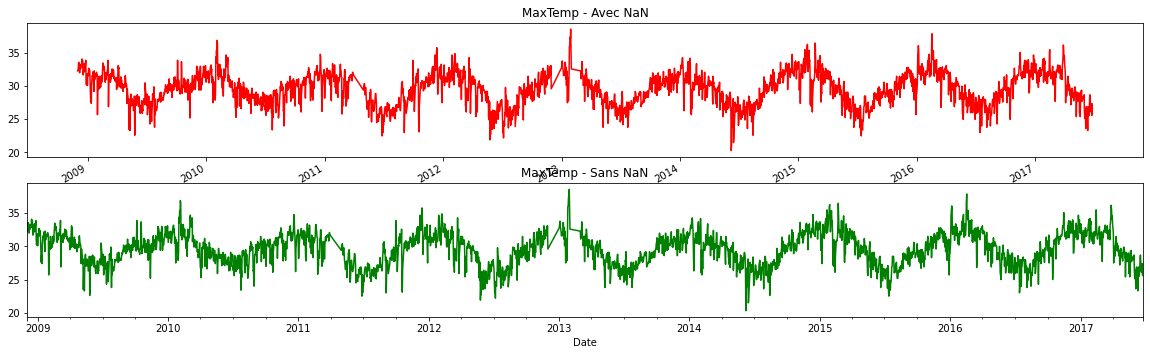

In [154]:
data = PredTemp["MaxTemp"]
data.index = pd.to_datetime(data.index)

data_interpol = PredTemp_interpol["MaxTemp"] 
data_interpol.index = pd.to_datetime(data_interpol.index)

plt.figure(figsize=(20,6));
plt.subplot(211);
data.plot(color="red");
plt.title(Indicateur+" - Avec NaN")
plt.subplot(212);
data_interpol.plot(color="green");
plt.title(Indicateur+" - Sans NaN");

#### Séries mensuelles - remplacement des valeurs des dates manquantes

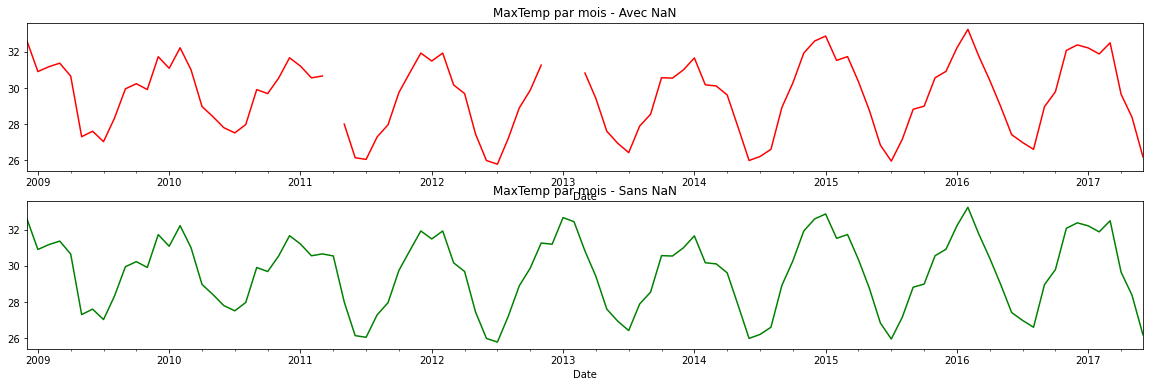

In [155]:
data_mois = data.resample('M').mean()
data_mois_interpol = data_interpol.resample('M').mean()

plt.figure(figsize=(20,6));
plt.subplot(211);
data_mois.plot(color="red");
plt.title(Indicateur+" par mois - Avec NaN")
plt.subplot(212);
data_mois_interpol.plot(color="green")
plt.title(Indicateur+" par mois - Sans NaN");

#### Transformée log

In [156]:
datalog = np.log(data)
data_mois_log = np.log(data_mois)

data_interpol_log = np.log(data_interpol)
data_mois_interpol_log = np.log(data_mois_interpol)

#### Décomposition de la série temporelle et visualisation de la saisonnalité

seasonal decompose - Cairns - additive


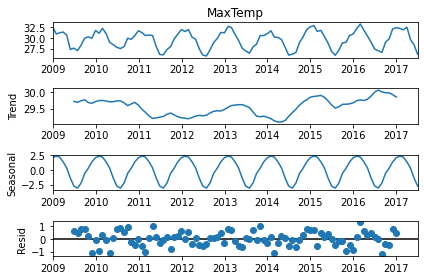

In [157]:
print("seasonal decompose - "+Ville+" - additive")
sd_ad = seasonal_decompose(data_mois_interpol, period=12)
sd_ad.plot()
plt.show();

seasonal decompose - Cairns - multiplicative


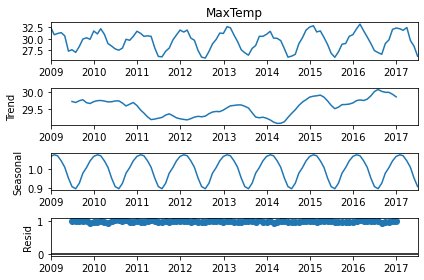

In [158]:
print("seasonal decompose - "+Ville+" - multiplicative")
sd_mu = seasonal_decompose(data_mois_interpol, period=12, model='multiplicative')
sd_mu.plot()
plt.show();

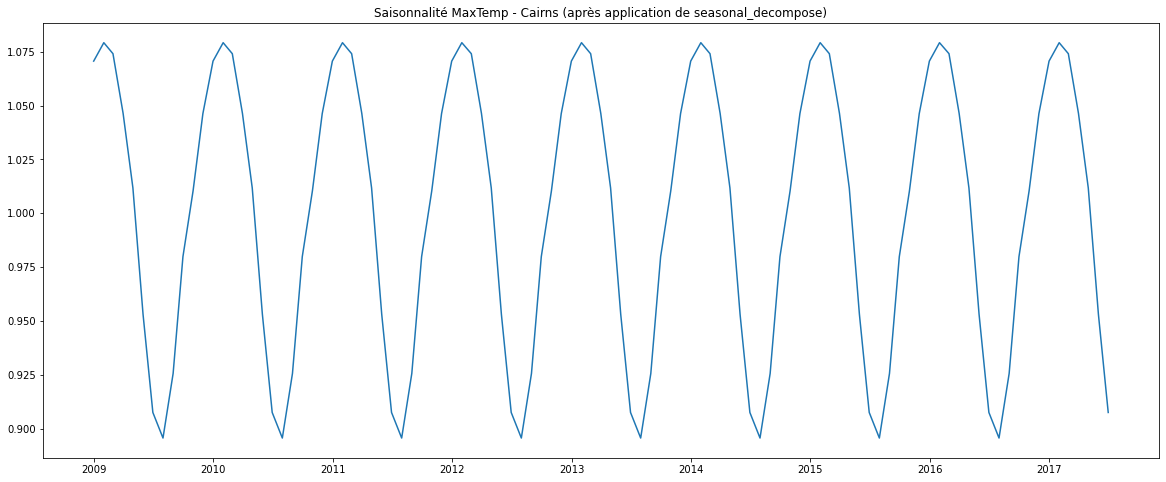

In [159]:
#Visualisation de la saisonnalité de la serie log
plt.figure(figsize=(20,8))
plt.plot(sd_mu.seasonal)
plt.title("Saisonnalité "+Indicateur+" - "+Ville+" (après application de seasonal_decompose)");

#### Autocorrelations

In [160]:
#séries non transformées
data_mois_interpol_1 = data_mois_interpol.diff().dropna()
data_mois_interpol_2 = data_mois_interpol_1.diff(periods = 12).dropna()

#transformées log
data_mois_interpol_log_1 = data_mois_interpol_log.diff().dropna()
data_mois_interpol_log_2 = data_mois_interpol_log_1.diff(periods = 12).dropna()

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


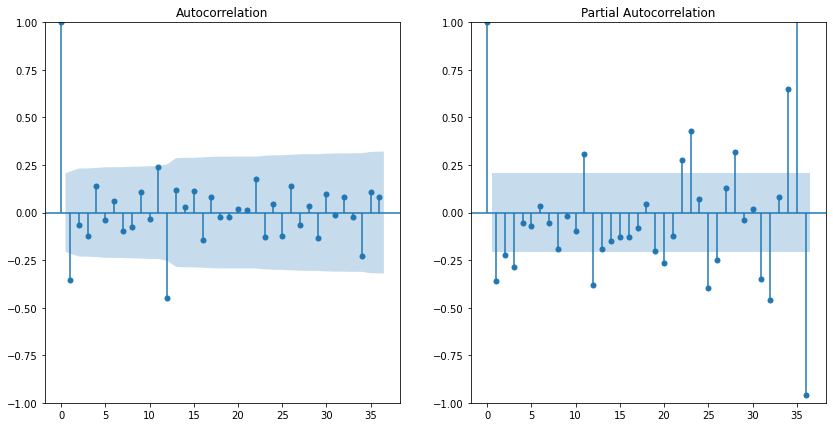

In [161]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plt.figure(figsize= (14,7))
plt.subplot(121)
plot_acf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.subplot(122)
plot_pacf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.show();

#### Modélisation SARIMA

##### Création et entrainement du modèle

In [162]:
# Réduction du jeu de donnée
# Les 24 derniers mois sont retirés du jeu d'entrainement afin de servir de test pour évaluer le modèle
data_mois_interpol_red = data_mois_interpol[0:len(data_mois_interpol)-24]
data_mois_interpol_log_red = data_mois_interpol_log[0:len(data_mois_interpol_log)-24]

In [163]:
#Recherche des meilleurs paramètres avec auto-arima
step_wise=auto_arima(data_mois_interpol_log_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=0, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=0,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=111)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-198.551, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-321.547, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-274.164, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=418.865, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-273.864, Time=0.12 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-331.954, Time=0.40 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-294.968, Time=0.22 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-330.419, Time=0.66 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-306.722, Time=0.46 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-328.758, Time=0.80 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-282.058, Time=0.35 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-315.259, Time=0.50 sec
 ARIMA(1,0,1)(1,0,1)[12] inter

In [164]:
#Entrainement du modèle Sarima et affichage des tests statistiques
sarima=sm.tsa.SARIMAX(data_mois_interpol_log_red,order=(1,0,0),seasonal_order=(1,0,1,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                       
Dep. Variable:                              MaxTemp   No. Observations:                   79
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 156.830
Date:                              Thu, 26 May 2022   AIC                           -305.659
Time:                                      16:39:13   BIC                           -296.181
Sample:                                  12-31-2008   HQIC                          -301.862
                                       - 06-30-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.003    337.983      0.000       0.993       1.005
ar.S.L12       0.94

##### Prédictions et évaluations

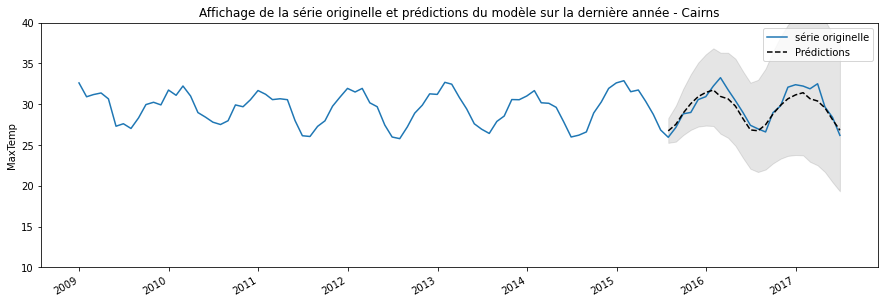

In [165]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(10,40)
prediction['mean'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend();

In [166]:
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  0.956
NRMSE_min_max :  0.131
NRMSE_moy :  0.032
MAE erreur absolue moyenne :  0.762  +/-  0.5906368303458565
MAPE % erreur absolue moyen :  2.499  %
WMAPE :  2.56  %


In [167]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.934138
prédictions  0.934138     1.000000

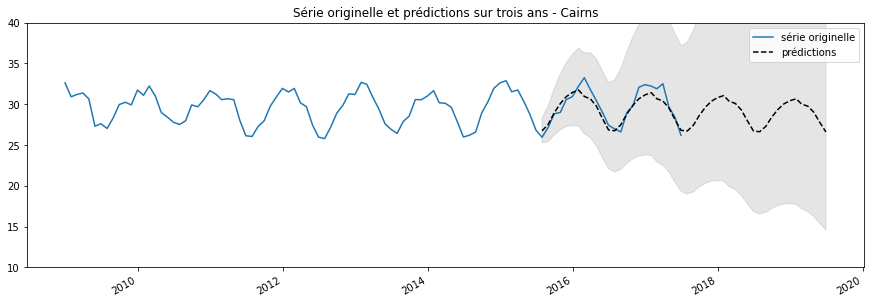

In [168]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance
plt.legend()
plt.ylim(10,40)
plt.title("Série originelle et prédictions sur trois ans - "+Ville);

#### Modélisation Prophet

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [169]:
df_prophet=pd.DataFrame({'ds':data_mois_interpol_red.index,'y':data_mois_interpol_red})
df_prophet.info()

# definition du modèle
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_prophet) 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2008-12-31 to 2015-06-30
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      79 non-null     datetime64[ns]
 1   y       79 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 KB


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


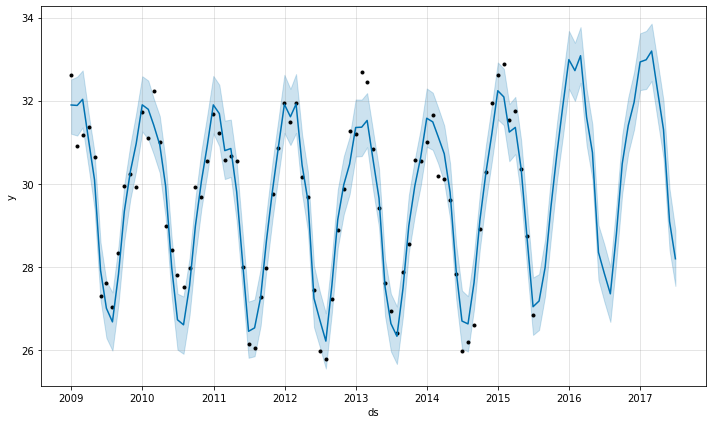

In [170]:
future = model.make_future_dataframe(periods=24,freq = 'M')
#future.head()

forecast = model.predict(future)
forecast.index = forecast["ds"]
forecast.index = pd.to_datetime(forecast.index)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


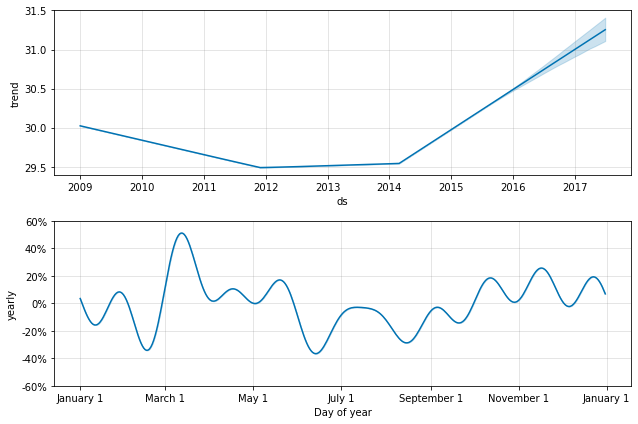

In [171]:
fig = model.plot_components(forecast)

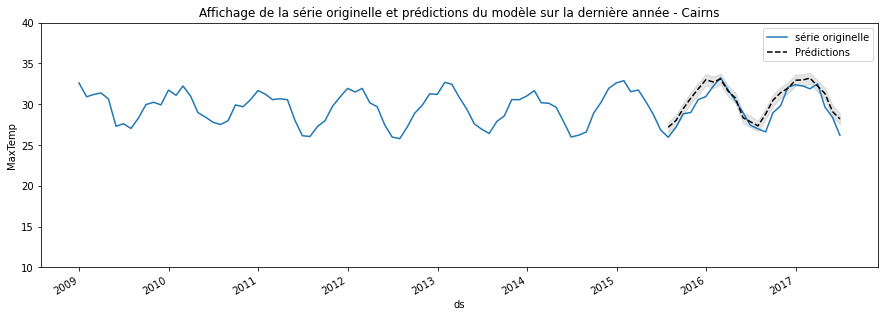

In [172]:
predictions = forecast.tail(24)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(10,40)
predictions['yhat'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(predictions.index, predictions['yhat_lower'], predictions['yhat_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend();

In [173]:
dfcomp = forecast.tail(24)
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'yhat':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  1.163
NRMSE_min_max :  0.159
NRMSE_moy :  0.039
MAE erreur absolue moyenne :  0.963  +/-  0.6653787843955706
MAPE % erreur absolue moyen :  3.324  %
WMAPE :  3.237  %


In [174]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.933729
prédictions  0.933729     1.000000

<hr>
<h2> 1.3 - Étude des séries temporelles appliquées à la variable précipitations i.e Rainfall </h2>
<hr>

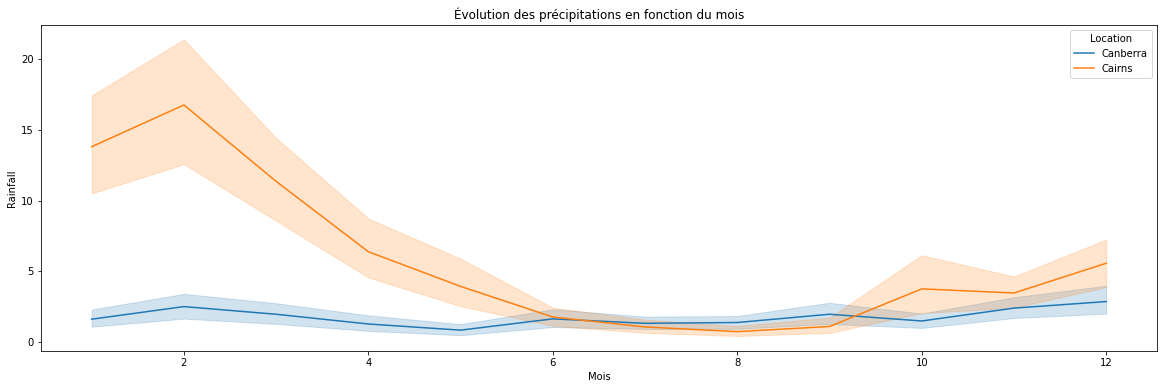

In [175]:
plt.figure(figsize=(20,6))
Graphe = Temp.reset_index()
sns.lineplot(data=Graphe, x="Mois", y="Rainfall", hue="Location")
plt.title("Évolution des précipitations en fonction du mois");

Observations :
La mousson estivale de Cairns masque l'évolution des précipations à Canberra sur le graphique, qui illustre ainsi la différence entre ces deux climats.

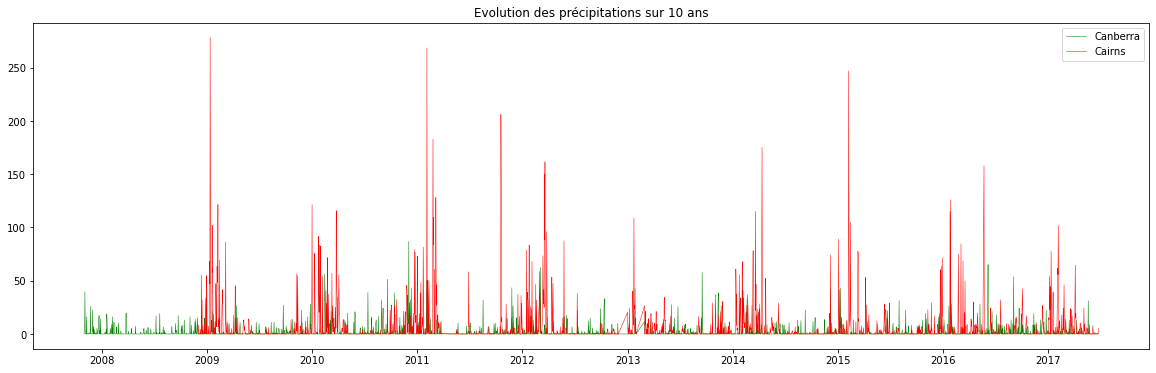

In [176]:
plt.figure(figsize=(20,6))
plt.plot(Temp[Temp["Location"] == "Canberra"]["Rainfall"],linewidth=0.5,color='green',label='Canberra')
plt.plot(Temp[Temp["Location"] == "Cairns"]["Rainfall"],linewidth=0.5,color='red',label='Cairns')
plt.legend()
plt.title("Evolution des précipitations sur 10 ans");

<hr>
<h3> 1.3.1 - Série temporelle - Précipitations i.e Rainfall - Canberra </h3>
<hr>

In [177]:
Ville = "Canberra"
Indicateur = "Rainfall"

PredTemp = Temp[Temp["Location"] == Ville][["Location", Indicateur]]

#gestion des valeurs manquantes en prenant moyenne des valeurs manquantes
#https://towardsdatascience.com/how-to-interpolate-time-series-data-in-apache-spark-and-python-pandas-part-1-pandas-cff54d76a2ea
PredTemp_interpol = PredTemp.groupby('Location').resample('D').mean()
PredTemp_interpol[Indicateur] = PredTemp_interpol[Indicateur].interpolate()
PredTemp_interpol = PredTemp_interpol.reset_index()
PredTemp_interpol.index = PredTemp_interpol["Date"]

#### Séries quotidiennes - remplacement des valeurs des dates manquantes

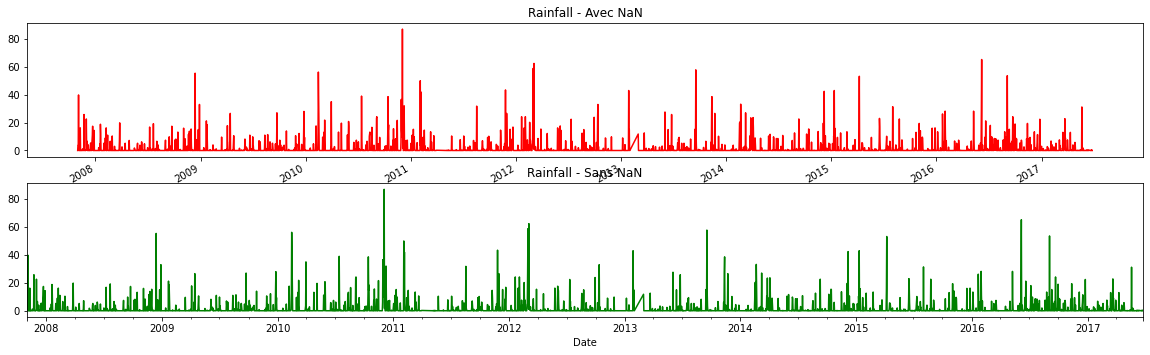

In [178]:
data = PredTemp["Rainfall"]
data.index = pd.to_datetime(data.index)

data_interpol = PredTemp_interpol["Rainfall"] 
data_interpol.index = pd.to_datetime(data_interpol.index)

plt.figure(figsize=(20,6))
plt.subplot(211)
data.plot(color="red")
plt.title(Indicateur+" - Avec NaN")
plt.subplot(212)
data_interpol.plot(color="green")
plt.title(Indicateur+" - Sans NaN");

#### Séries mensuelles - remplacement des valeurs des dates manquantes

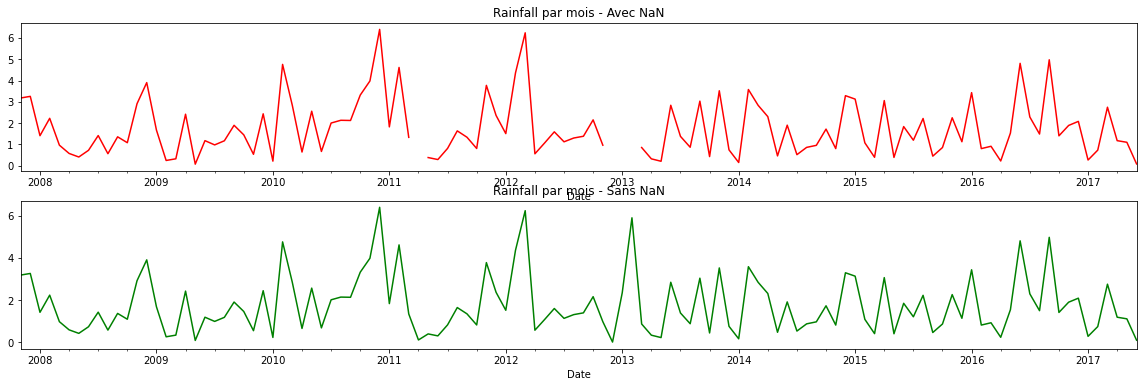

In [179]:
data_mois = data.resample('M').mean()
data_mois_interpol = data_interpol.resample('M').mean()

plt.figure(figsize=(20,6))
plt.subplot(211)
data_mois.plot(color="red")
plt.title(Indicateur+" par mois - Avec NaN")
plt.subplot(212)
data_mois_interpol.plot(color="green")
plt.title(Indicateur+" par mois - Sans NaN");

#### Transformées log

In [180]:
#légère augmentation des valeurs nulles pour les calculs de logarithme
data1 = data.replace(0, 0.01)
data_mois1 = data_mois.replace(0, 0.01)
data_interpol1 = data_interpol.replace(0, 0.01)
data_mois_interpol1 = data_mois_interpol.replace(0, 0.01)

#transformée en log
datalog = np.log(data1)
data_mois_log = np.log(data_mois1)

data_interpol_log = np.log(data_interpol1)
data_mois_interpol_log = np.log(data_mois_interpol1)

#### Décomposition de la série temporelle et visualisation de la saisonnalité

seasonal decompose - Canberra - additive


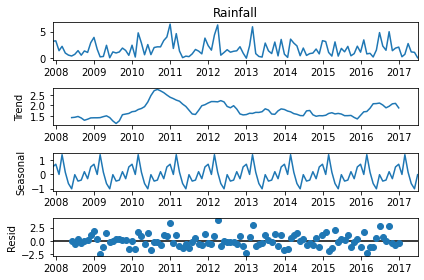

In [181]:
print("seasonal decompose - "+Ville+" - additive")
sd_ad = seasonal_decompose(data_mois_interpol, period=12)
sd_ad.plot()
plt.show();

seasonal decompose - Canberra - multiplicative


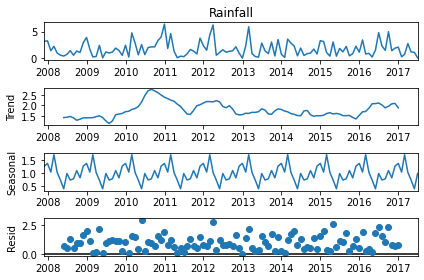

In [182]:
print("seasonal decompose - "+Ville+" - multiplicative")
sd_mu = seasonal_decompose(data_mois_interpol1, period=12, model='multiplicative')
sd_mu.plot()
plt.show();

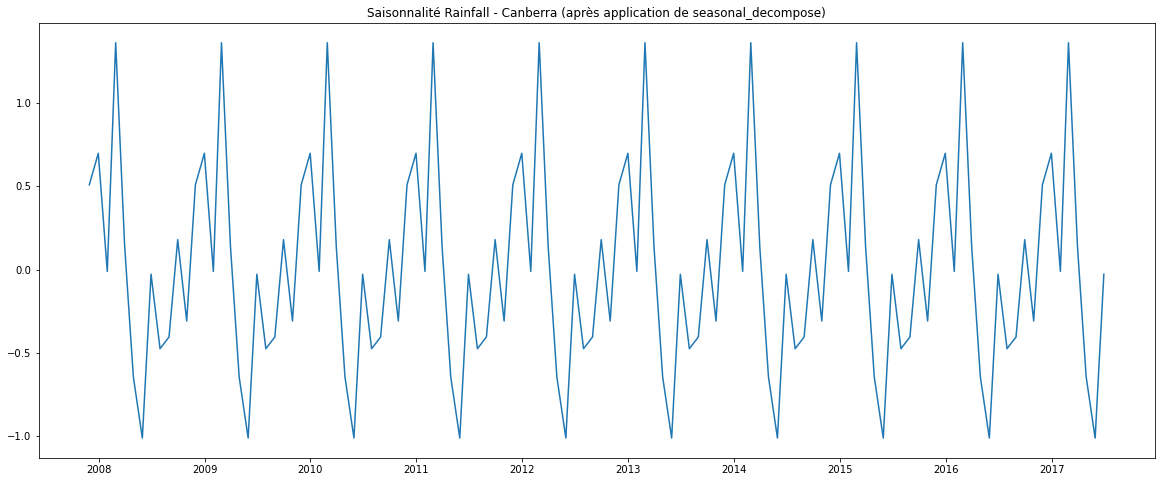

In [183]:
#Visualisation de la saisonnalité des deux séries
plt.figure(figsize=(20,8))
plt.plot(sd_ad.seasonal)
plt.title("Saisonnalité "+Indicateur+" - "+Ville+" (après application de seasonal_decompose)");

In [184]:
#séries non transformées
data_mois_interpol_1 = data_mois_interpol.diff().dropna()
data_mois_interpol_2 = data_mois_interpol_1.diff(periods = 12).dropna()

#transformées log
data_mois_interpol_log_1 = data_mois_interpol_log.diff().dropna()
data_mois_interpol_log_2 = data_mois_interpol_log_1.diff(periods = 12).dropna()

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


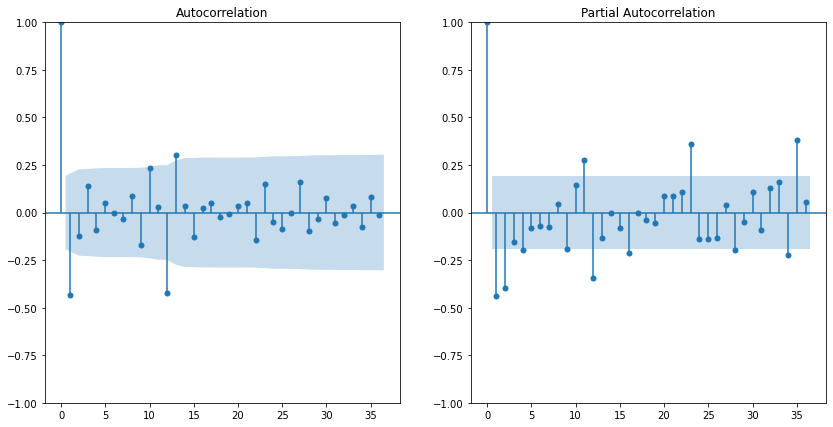

In [185]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plt.figure(figsize= (14,7))
plt.subplot(121)
plot_acf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.subplot(122)
plot_pacf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.show();

#### Modélisation SARIMA

##### Réduction du jeu de donnée

In [186]:
# Les 24 derniers mois sont retirés du jeu d'entrainement afin de servir de test pour évaluer le modèle
data_mois_interpol_red = data_mois_interpol[0:len(data_mois_interpol)-24]
data_mois_interpol_log_red = data_mois_interpol_log[0:len(data_mois_interpol_log)-24]

##### Sans transformée log

In [187]:
#Recherche des meilleurs paramètres avec auto-arima
step_wise=auto_arima(data_mois_interpol_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=0, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=0,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=111)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=328.671, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=328.281, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=329.111, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=413.914, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=329.163, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=326.072, Time=0.24 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=328.059, Time=0.67 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=328.062, Time=0.56 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=327.628, Time=0.32 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=330.032, Time=1.71 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=325.239, Time=0.26 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=327.480, Time=0.10 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=327.235, Time=0.48 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=327.236, Time=0.34 sec
 ARIMA(0,0,0)(1,0,1)[12] intercep

In [188]:
#Entrainement du modèle Sarima et affichage des tests statistiques
sarima=sm.tsa.SARIMAX(data_mois_interpol_red,order=(0,0,0),seasonal_order=(2,0,0,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

                                SARIMAX Results                                 
Dep. Variable:                 Rainfall   No. Observations:                   92
Model:             SARIMAX(2, 0, 0, 12)   Log Likelihood                -172.404
Date:                  Thu, 26 May 2022   AIC                            350.809
Time:                          16:39:35   BIC                            358.374
Sample:                      11-30-2007   HQIC                           353.862
                           - 06-30-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3713      0.089      4.156      0.000       0.196       0.546
ar.S.L24       0.4228      0.076      5.571      0.000       0.274       0.572
sigma2         2.2011      0.294    

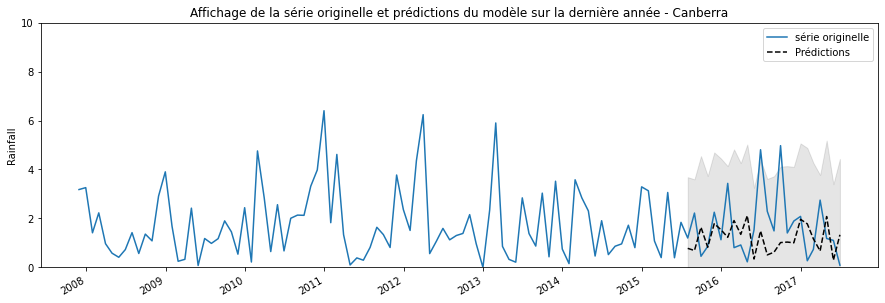

In [189]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(0,10)
prediction['mean'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend(); 

In [190]:
#calcul des erreurs du modèle
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', 'Rainfall':'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)

In [191]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE/(dfcomp.réalité.max() - dfcomp.réalité.min())
NRMSE_moy = RMSE/dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions)/dfcomp.réalité).sum()/len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE =", RMSE)
print("NRMSE min max =", NRMSE_min_max)
print("NRMSE moy =", NRMSE_moy)

print("MAE =", MAE, "+/-", dfcomp.erreur.std())
print("MAPE =", 100*MAPE," %")
print("WMAPE =", 100*WMAPE," %")

RMSE = 1.5396145999733502
NRMSE min max = 0.31515036844432665
NRMSE moy = 0.9214387070560246
MAE = 1.2144176877207793 +/- 0.9667171500551742
MAPE = 175.0527673557094  %
WMAPE = 72.68127127521208  %


In [192]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000    -0.194614
prédictions -0.194614     1.000000

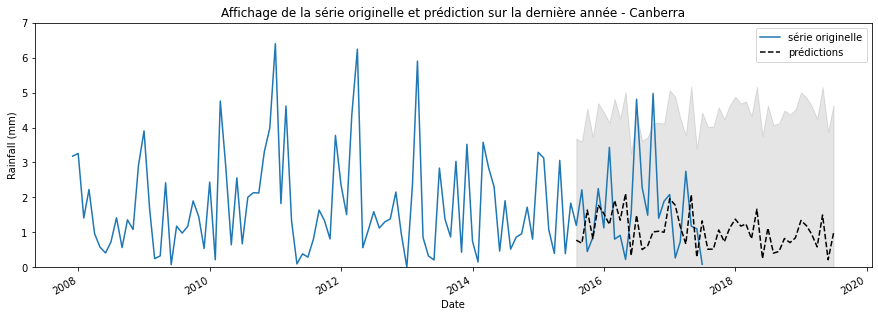

In [193]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance

plt.legend()
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim([0,7])
plt.title("Affichage de la série originelle et prédiction sur la dernière année - "+Ville);

##### Avec transformée log

In [194]:
#Recherche des meilleurs paramètres avec auto-arima
step_wise=auto_arima(data_mois_interpol_log_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=1, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=1,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=112)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=343.216, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=308.558, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=327.432, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=306.532, Time=0.18 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=305.861, Time=0.37 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=305.786, Time=0.75 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.95 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.37 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=8.45 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=320.711, Time=0.67 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=291.954, Time=1.10 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=292.293, Time=0.39 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=inf, Time=

In [195]:
#Entrainement du modèle Sarima et affichage des tests statistiques
sarima=sm.tsa.SARIMAX(data_mois_interpol_log_red,order=(4,1,0),seasonal_order=(3,1,0,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Rainfall   No. Observations:                   92
Model:             SARIMAX(4, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -135.564
Date:                            Thu, 26 May 2022   AIC                            287.128
Time:                                    16:41:03   BIC                            306.083
Sample:                                11-30-2007   HQIC                           294.722
                                     - 06-30-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8175      0.115     -7.091      0.000      -1.043      -0.592
ar.L2         -0.7203      0.149   

In [196]:
#Entrainement du modèle Sarima et affichage des tests statistiques
sarima=sm.tsa.SARIMAX(data_mois_interpol_log_red,order=(3,1,0),seasonal_order=(3,1,0,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Rainfall   No. Observations:                   92
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -137.735
Date:                            Thu, 26 May 2022   AIC                            289.470
Time:                                    16:41:03   BIC                            306.056
Sample:                                11-30-2007   HQIC                           296.115
                                     - 06-30-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7464      0.105     -7.135      0.000      -0.951      -0.541
ar.L2         -0.5813      0.120   

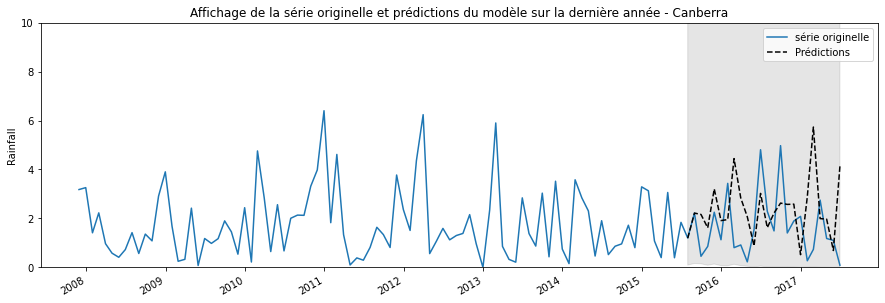

In [197]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(0,10)
prediction['mean'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend(); 

In [198]:
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', 'Rainfall':'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)

In [199]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE/(dfcomp.réalité.max() - dfcomp.réalité.min())
NRMSE_moy = RMSE/dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions)/dfcomp.réalité).sum()/len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE =", RMSE)
print("NRMSE min max =", NRMSE_min_max)
print("NRMSE moy =", NRMSE_moy)

print("MAE =", MAE, "+/-", dfcomp.erreur.std())
print("MAPE =", 100*MAPE," %")
print("WMAPE =", 100*WMAPE," %")

RMSE = 1.9510359615137607
NRMSE min max = 0.39936598557186703
NRMSE moy = 1.1676688788403058
MAE = 1.5123832372170518 +/- 1.2590838354122047
MAPE = 369.0522076856781  %
WMAPE = 90.51411013500437  %


In [200]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000    -0.124463
prédictions -0.124463     1.000000

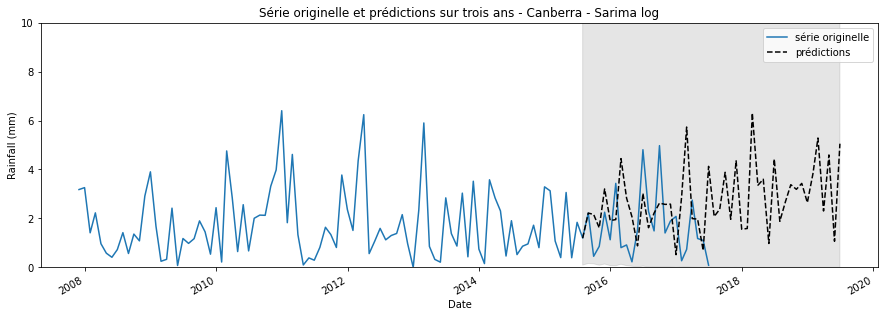

In [201]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance

plt.legend()
plt.ylim([0,10])
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.title("Série originelle et prédictions sur trois ans - "+Ville+" - Sarima log");

#### Modélisation - Prophet

In [202]:
df_prophet=pd.DataFrame({'ds':data_mois_interpol_red.index,'y':data_mois_interpol_red})
df_prophet.info()

# definition du modèle
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_prophet) 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2007-11-30 to 2015-06-30
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      92 non-null     datetime64[ns]
 1   y       92 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


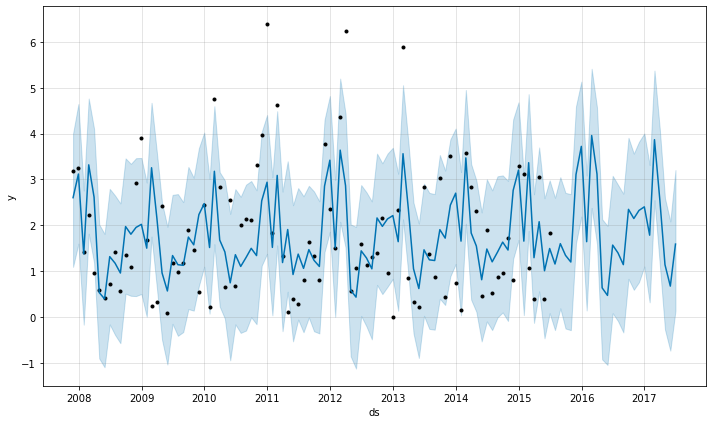

In [203]:
future = model.make_future_dataframe(periods=24,freq = 'M')
#future.head()

forecast = model.predict(future)
forecast.index = forecast["ds"]
forecast.index = pd.to_datetime(forecast.index)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast)

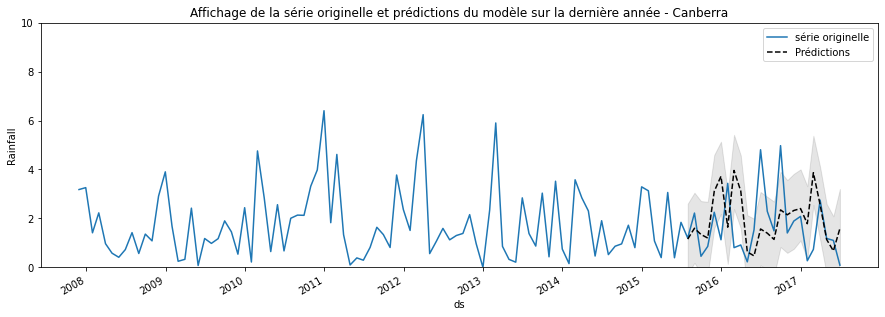

In [204]:
predictions = forecast.tail(24)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(0,10)
predictions['yhat'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(predictions.index, predictions['yhat_lower'], predictions['yhat_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend();

In [205]:
dfcomp = forecast.tail(24)
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'yhat':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  1.604
NRMSE_min_max :  0.328
NRMSE_moy :  0.96
MAE erreur absolue moyenne :  1.224  +/-  1.0596862497513369
MAPE % erreur absolue moyen :  186.765  %
WMAPE :  73.226  %


In [206]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.036808
prédictions  0.036808     1.000000

<hr>
<h3> 1.3.2 - Série temporelle - Précipitations i.e Rainfall - Cairns </h3>
<hr>

In [207]:
Ville = "Cairns"
Indicateur = "Rainfall"

PredTemp = Temp[Temp["Location"] == Ville][["Location", Indicateur]]

#gestion des valeurs manquantes en prenant moyenne des valeurs manquantes
#https://towardsdatascience.com/how-to-interpolate-time-series-data-in-apache-spark-and-python-pandas-part-1-pandas-cff54d76a2ea
PredTemp_interpol = PredTemp.groupby('Location').resample('D').mean()
PredTemp_interpol[Indicateur] = PredTemp_interpol[Indicateur].interpolate()
PredTemp_interpol = PredTemp_interpol.reset_index()
PredTemp_interpol.index = PredTemp_interpol["Date"]

#### Séries quotidiennes - remplacement des valeurs des dates manquantes

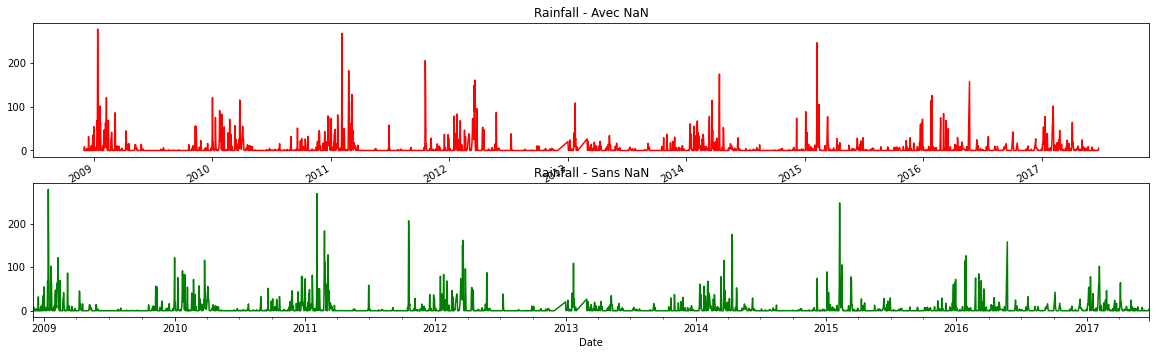

In [208]:
data = PredTemp["Rainfall"]
data.index = pd.to_datetime(data.index)

data_interpol = PredTemp_interpol["Rainfall"] 
data_interpol.index = pd.to_datetime(data_interpol.index)

plt.figure(figsize=(20,6))
plt.subplot(211)
data.plot(color="red")
plt.title(Indicateur+" - Avec NaN")
plt.subplot(212)
data_interpol.plot(color="green")
plt.title(Indicateur+" - Sans NaN");

#### Séries mensuelles - remplacement des valeurs des dates manquantes

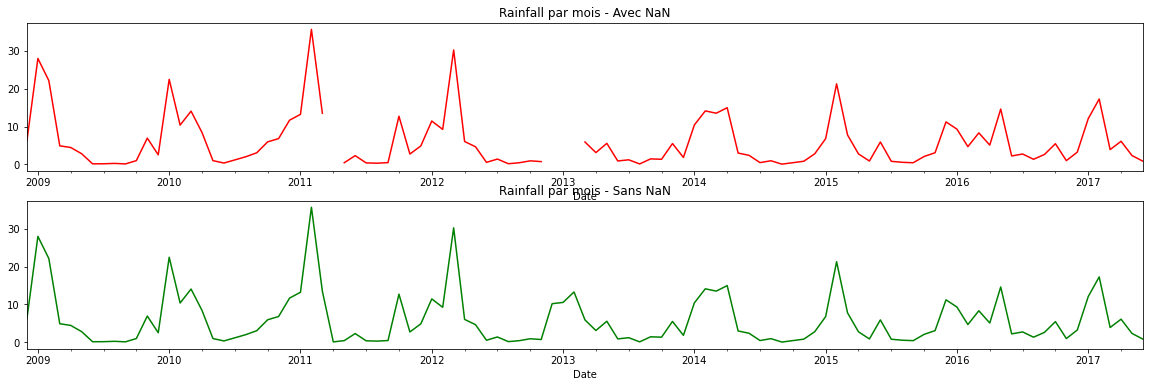

In [209]:
data_mois = data.resample('M').mean()
data_mois_interpol = data_interpol.resample('M').mean()

plt.figure(figsize=(20,6))
plt.subplot(211)
data_mois.plot(color="red")
plt.title(Indicateur+" par mois - Avec NaN")
plt.subplot(212)
data_mois_interpol.plot(color="green")
plt.title(Indicateur+" par mois - Sans NaN");

#### Transformées log

In [210]:
#légère augmentation des valeurs nulles pour les calculs de logarithme
data1 = data.replace(0, 0.01)
data_mois1 = data_mois.replace(0, 0.01)
data_interpol1 = data_interpol.replace(0, 0.01)
data_mois_interpol1 = data_mois_interpol.replace(0, 0.01)

#transformée en log
datalog = np.log(data1)
data_mois_log = np.log(data_mois1)

data_interpol_log = np.log(data_interpol1)
data_mois_interpol_log = np.log(data_mois_interpol1)

#### Décomposition de la série temporelle et visualisation de la saisonnalité

seasonal decompose - Cairns - additive


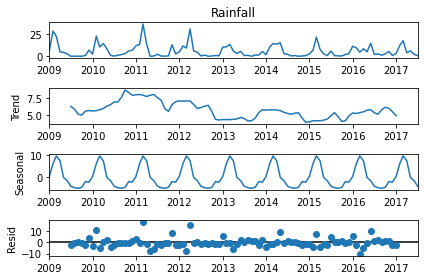

In [211]:
print("seasonal decompose - "+Ville+" - additive")
sd_ad = seasonal_decompose(data_mois_interpol, period=12)
sd_ad.plot()
plt.show();

seasonal decompose - Cairns - multiplicative


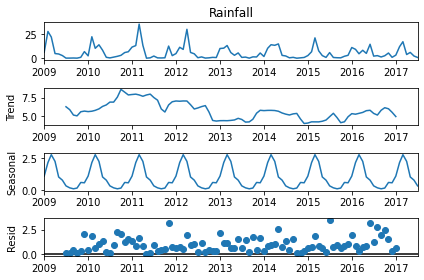

In [212]:
print("seasonal decompose - "+Ville+" - multiplicative")
sd_mu = seasonal_decompose(data_mois_interpol1, period=12, model='multiplicative')
sd_mu.plot()
plt.show();

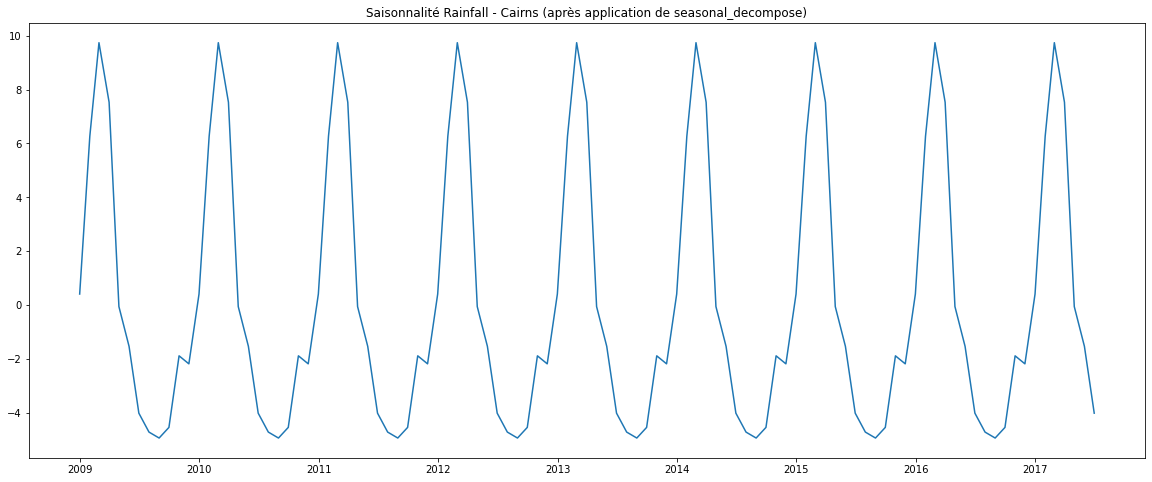

In [213]:
#Visualisation de la saisonnalité des deux séries
plt.figure(figsize=(20,8))
plt.plot(sd_ad.seasonal)
plt.title("Saisonnalité "+Indicateur+" - "+Ville+" (après application de seasonal_decompose)");

#### Autocorrélations

In [214]:
#séries non transformées
data_mois_interpol_1 = data_mois_interpol.diff().dropna()
data_mois_interpol_2 = data_mois_interpol_1.diff(periods = 12).dropna()

#transformées log
data_mois_interpol_log_1 = data_mois_interpol_log.diff().dropna()
data_mois_interpol_log_2 = data_mois_interpol_log_1.diff(periods = 12).dropna()

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


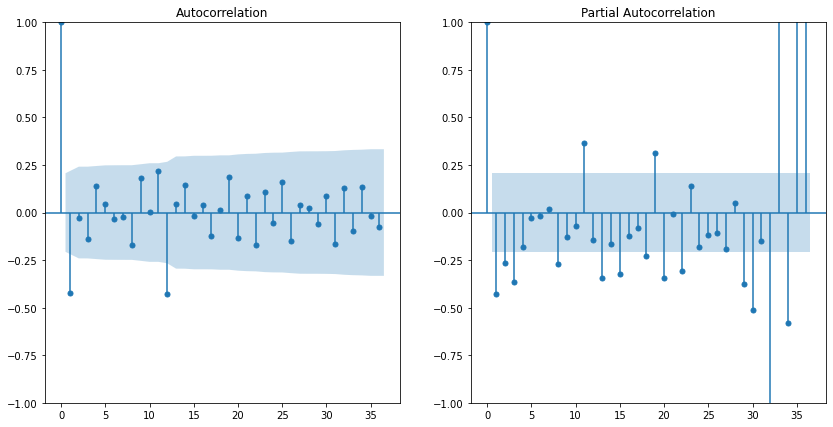

In [215]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plt.figure(figsize= (14,7))
plt.subplot(121)
plot_acf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.subplot(122)
plot_pacf(data_mois_interpol_log_2, lags = 36, ax=plt.gca())
plt.show();

#### Modélisation SARIMA

##### Réduction du jeu de données

In [216]:
# Les 24 derniers mois sont retirés du jeu d'entrainement afin de servir de test pour évaluer le modèle
data_mois_interpol_red = data_mois_interpol[0:len(data_mois_interpol)-24]
data_mois_interpol_log_red = data_mois_interpol_log[0:len(data_mois_interpol_log)-24]

##### Sans transformée log

In [217]:
#Recherche des meilleurs paramètres avec auto-arima
step_wise=auto_arima(data_mois_interpol_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=0, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=0,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=121)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=545.237, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=528.769, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=533.181, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=584.979, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=531.568, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=514.999, Time=0.35 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=516.996, Time=0.71 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=516.432, Time=0.64 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=516.703, Time=0.69 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=513.035, Time=0.22 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=528.625, Time=0.11 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=515.033, Time=0.44 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=514.670, Time=0.45 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   

In [218]:
#Entrainement du modèle Sarima et affichage des tests statistiques
sarima=sm.tsa.SARIMAX(data_mois_interpol_red,order=(0,0,0),seasonal_order=(2,0,0,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

                                SARIMAX Results                                 
Dep. Variable:                 Rainfall   No. Observations:                   79
Model:             SARIMAX(2, 0, 0, 12)   Log Likelihood                -257.104
Date:                  Thu, 26 May 2022   AIC                            520.209
Time:                          16:41:31   BIC                            527.317
Sample:                      12-31-2008   HQIC                           523.057
                           - 06-30-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3401      0.070      4.827      0.000       0.202       0.478
ar.S.L24       0.5220      0.081      6.436      0.000       0.363       0.681
sigma2        32.0480      4.603    

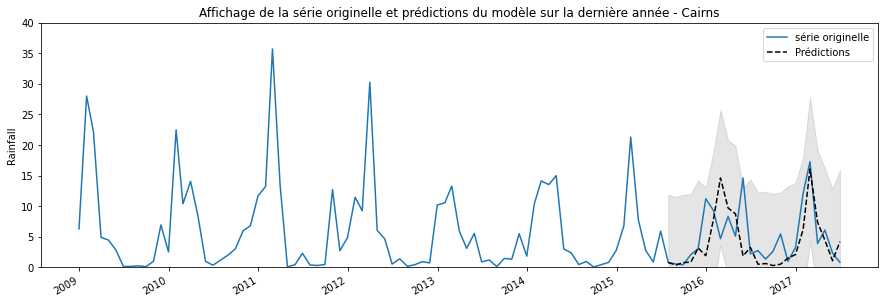

In [219]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(0,40)
prediction['mean'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend(); 

In [220]:
#calcul des erreurs du modèle
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', 'Rainfall':'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)

In [221]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE/(dfcomp.réalité.max() - dfcomp.réalité.min())
NRMSE_moy = RMSE/dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions)/dfcomp.réalité).sum()/len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE =", RMSE)
print("NRMSE min max =", NRMSE_min_max)
print("NRMSE moy =", NRMSE_moy)

print("MAE =", MAE, "+/-", dfcomp.erreur.std())
print("MAPE =", 100*MAPE," %")
print("WMAPE =", 100*WMAPE," %")

RMSE = 4.423693101524341
NRMSE min max = 0.26260792970179836
NRMSE moy = 0.8743846002407009
MAE = 2.925271577844408 +/- 3.3897821172504625
MAPE = 72.39023590430612  %
WMAPE = 57.82074751766982  %


In [222]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.541387
prédictions  0.541387     1.000000

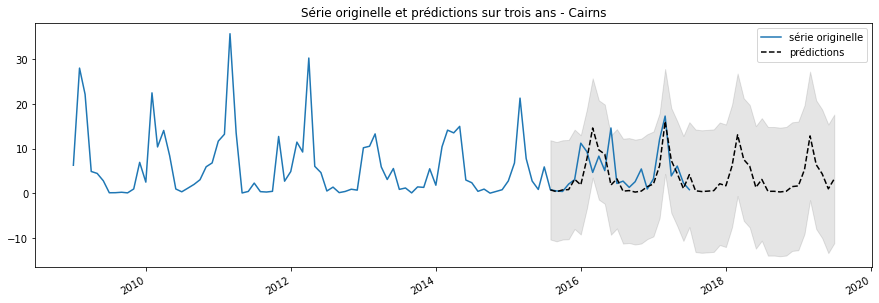

In [223]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance
plt.legend()
plt.title("Série originelle et prédictions sur trois ans - "+Ville);

##### Avec transformée log

In [224]:
#Recherche des meilleurs paramètres avec auto-arima
step_wise=auto_arima(data_mois_interpol_log_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=0, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=0,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=112)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=299.031, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=266.721, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=274.574, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=320.906, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=268.405, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=265.616, Time=0.25 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=266.495, Time=0.55 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=269.863, Time=0.17 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=266.945, Time=0.29 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=267.237, Time=0.27 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=267.664, Time=0.13 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=26

In [225]:
#Entrainement du modèle Sarima et affichage des tests statistiques
sarima=sm.tsa.SARIMAX(data_mois_interpol_log_red,order=(1,0,0),seasonal_order=(2,0,0,12))
sarima_fitted=sarima.fit()
print(sarima_fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Rainfall   No. Observations:                   79
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -130.338
Date:                            Thu, 26 May 2022   AIC                            268.675
Time:                                    16:41:38   BIC                            278.153
Sample:                                12-31-2008   HQIC                           272.472
                                     - 06-30-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3783      0.138      2.738      0.006       0.108       0.649
ar.S.L12       0.3190      0.132   

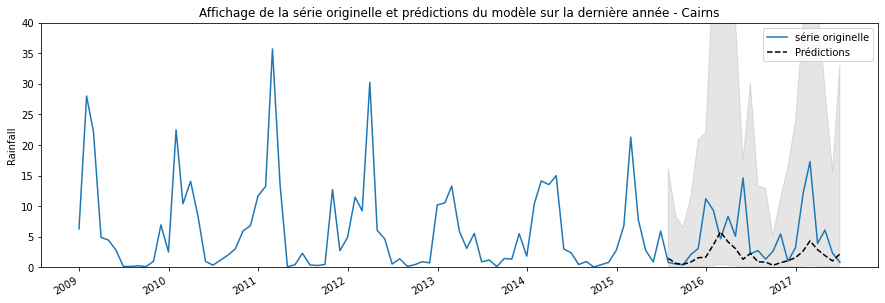

In [226]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label = "série originelle")
plt.ylim(0,40)
prediction['mean'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville)
plt.legend(); 

In [227]:
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', 'Rainfall':'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)

In [228]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE/(dfcomp.réalité.max() - dfcomp.réalité.min())
NRMSE_moy = RMSE/dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions)/dfcomp.réalité).sum()/len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE =", RMSE)
print("NRMSE min max =", NRMSE_min_max)
print("NRMSE moy =", NRMSE_moy)

print("MAE =", MAE, "+/-", dfcomp.erreur.std())
print("MAPE =", 100*MAPE," %")
print("WMAPE =", 100*WMAPE," %")

RMSE = 5.1587545500278225
NRMSE min max = 0.3062440863620757
NRMSE moy = 1.0196764177450826
MAE = 3.361605508536195 +/- 3.9972630087070335
MAPE = 57.516196781222654  %
WMAPE = 66.44529856141027  %


In [229]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.472347
prédictions  0.472347     1.000000

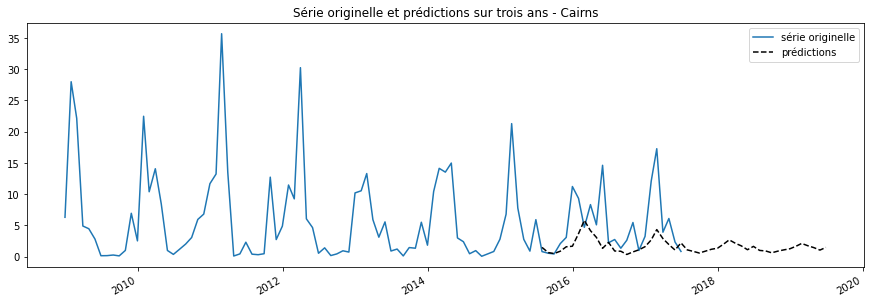

In [230]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(data_mois_interpol, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
#ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance
plt.legend()
plt.title("Série originelle et prédictions sur trois ans - "+Ville);

#### Modélisation Prophet

In [231]:
df_prophet=pd.DataFrame({'ds':data_mois_interpol_red.index,'y':data_mois_interpol_red})
df_prophet.info()

# definition du modèle
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_prophet) 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2008-12-31 to 2015-06-30
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      79 non-null     datetime64[ns]
 1   y       79 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 KB


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


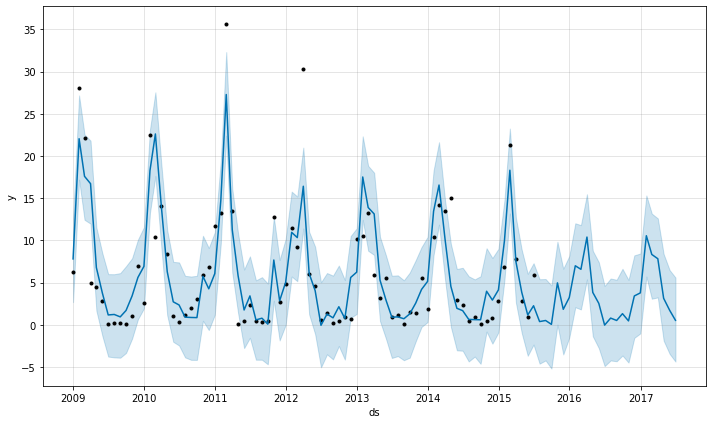

In [232]:
future = model.make_future_dataframe(periods=24,freq = 'M')
#future.head()

forecast = model.predict(future)
forecast.index = forecast["ds"]
forecast.index = pd.to_datetime(forecast.index)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast)


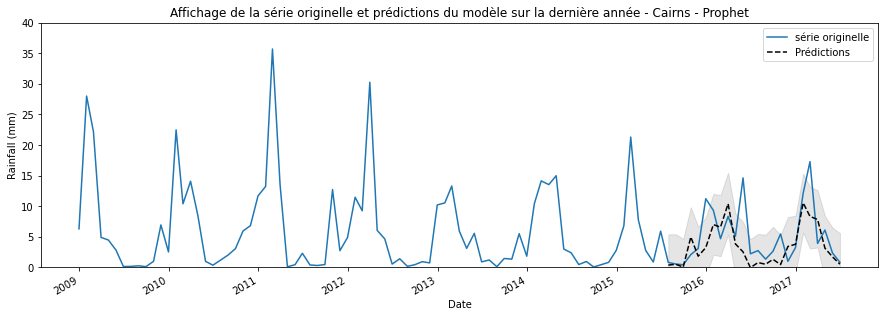

In [233]:
predictions = forecast.tail(24)

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(data_mois_interpol, label = "série originelle")

predictions['yhat'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(predictions.index, predictions['yhat_lower'], predictions['yhat_upper'], color='k', alpha=0.1)

plt.xlabel("Date")
plt.ylabel(Indicateur+" (mm)")
plt.ylim(0,40)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+Ville+" - Prophet")
plt.legend();

In [234]:
dfcomp = forecast.tail(24)
dfcomp = dfcomp.join(data_mois_interpol.tail(24))
dfcomp = dfcomp.rename(columns={'yhat':'prédictions', Indicateur:'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)
#print("Comparaison des valeurs réelles et prédites :")
#dfcomp

RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  4.003
NRMSE_min_max :  0.238
NRMSE_moy :  0.791
MAE erreur absolue moyenne :  2.717  +/-  3.003052437723378
MAPE % erreur absolue moyen :  63.017  %
WMAPE :  53.713  %


In [235]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.00000      0.61008
prédictions  0.61008      1.00000

<hr>
<h2> CONCLUSION de la partie 1 : séries temporelles des deux villes </h2>
<hr>

Comme on pouvait s’y attendre, les variations aléatoires quotidiennes rendent les prédictions plus difficiles sur Rainfall que sur MaxTemp, comme le montre la superposition des courbes des prédictions et de la série originelle.  Pour MaxTemp, le coefficient de corrélation dépasse en effet 90 % pour tous les modèles. Humidity3pm présente sur ce point, un profil intermédiaire.

Pour les trois indicateurs météorologiques, les performances sont meilleures sur Cairns par rapport à Canberra. La différence entre les deux villes est particulièrement marquée pour Rainfall, avec un coefficient de corrélation de 61 % pour Cairns (comparable à celui d’Humidity), alors qu’il n’est que de 20 % pour Canberra. Cette différence peut s’expliquer si l’on prend en compte le climat des deux villes. Cairns présente en effet un climat tropical, avec des saisons plus marquées en termes de précipitations que Canberra, dont le climat est océanique.

<hr>
<h1> 2 - Climat tropical* et climat méditerranéen </h1>
*inclut le climat subtropical humide
<hr>

L'objectif de cette étude est d'étudier les séries temporelles de Rainfall en s'appuyant sur l'expertise métier suivante : 
Les climats tropicaux (Am et Aw) et méditerranéen (Csa et Csb) présentent une saison sèche et une saison humide opposées. On observe en effet une mousson estivale en climat tropical et une mousson hivernale en climat méditerranéen.
Ces deux climats sont donc particulièrement bien adaptés pour les prédictions mensuelles des précipitations.

In [309]:
climats = ["Am", "Aw", "Csa", "Csb"]
clims = pd.DataFrame()
for i in climats:
    clims_temp = df[df["Climat_Koppen"] == i]
    clims = pd.concat([clims, clims_temp])
    
clims.index = pd.to_datetime(clims.index)

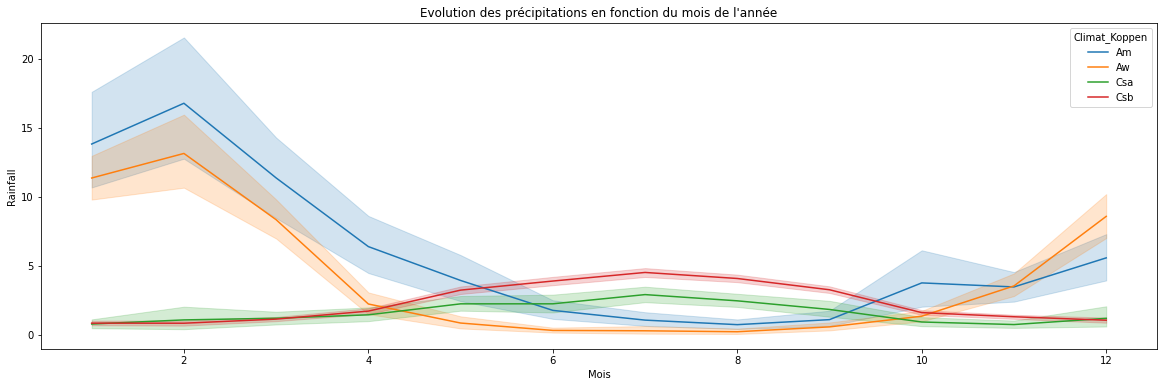

In [311]:
plt.figure(figsize=(20,6))
Graphe = clims.reset_index()
sns.lineplot(data=Graphe, x="Mois", y="Rainfall", hue="Climat_Koppen")
plt.title("Evolution des précipitations en fonction du mois de l'année");

Observations :
Les climats méditerranéen et tropical présentent une saison des pluie inversée. Les précipitations sont globalement plus élevées sous les latitudes tropicales.

## Préparation des séries temporelles

In [318]:
# CLIMAT TROPICAL

pred_trop = clims[(clims["Climat_Koppen"] == "Am") | (clims["Climat_Koppen"] == "Aw")][["Climat_Koppen", "Rainfall"]]
pred_trop = pred_trop.replace(["Am", "Aw"], ["tropical", "tropical"])

#gestion des valeurs manquantes en prenant moyenne des valeurs manquantes
pred_trop_interpol = pred_trop.groupby('Climat_Koppen').resample('D').mean()
pred_trop_interpol["Rainfall"] = pred_trop_interpol["Rainfall"].interpolate()
pred_trop_interpol = pred_trop_interpol.reset_index()
pred_trop_interpol.index = pred_trop_interpol["Date"]

data_interpol = pred_trop_interpol["Rainfall"] 
data_interpol.index = pd.to_datetime(data_interpol.index)
data_interpol = data_interpol.resample('D').mean()

ser_trop = data_interpol.resample('M',label='left',closed='left').mean()

In [319]:
#CLIMAT MEDITERRANEEN

pred_med = clims[(clims["Climat_Koppen"] == "Csa") | (clims["Climat_Koppen"] == "Csb")][["Climat_Koppen", "Rainfall"]]
pred_med = pred_med.replace(["Csa", "Csb"], ["méditerranéen", "méditerranéen"])

#gestion des valeurs manquantes en prenant moyenne des valeurs manquantes
pred_med_interpol = pred_med.groupby('Climat_Koppen').resample('D').mean()
pred_med_interpol["Rainfall"] = pred_med_interpol["Rainfall"].interpolate()
pred_med_interpol = pred_med_interpol.reset_index()
pred_med_interpol.index = pred_med_interpol["Date"]

data_interpol = pred_med_interpol["Rainfall"] 
data_interpol.index = pd.to_datetime(data_interpol.index)
data_interpol = data_interpol.resample('D').mean()

ser_med = data_interpol.resample('M',label='left',closed='left').mean()

## Visualisation des séries temporelles

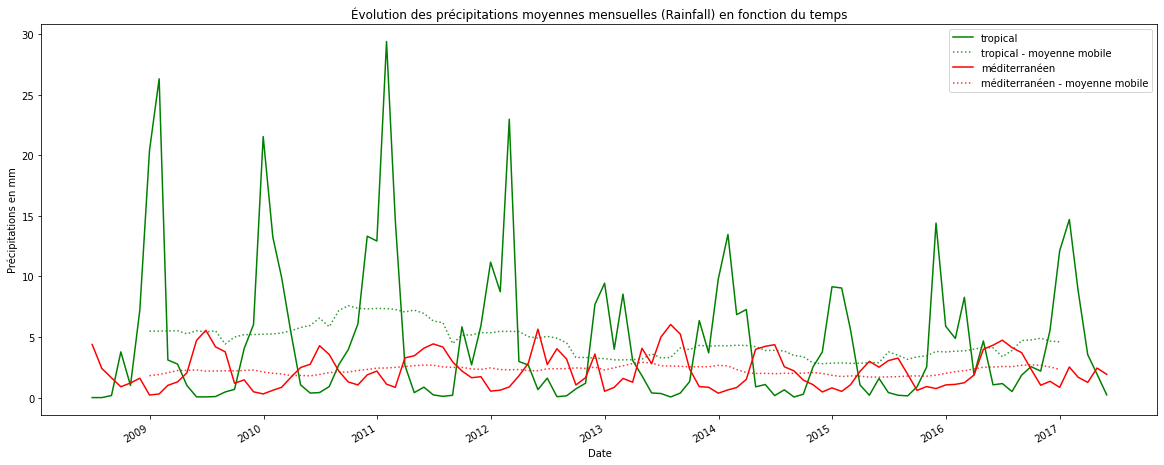

In [320]:
#Visualisation des deux séries temporelles
plt.figure(figsize=(20,8))

plt.plot(ser_trop, color='green', label='tropical')
ser_trop.rolling(window=12, center=True).mean().plot(color='green', label='tropical - moyenne mobile', ls=':', alpha=0.8)

plt.plot(ser_med, color='red', label='méditerranéen')
ser_med.rolling(window=12, center=True).mean().plot(color='red', label='méditerranéen - moyenne mobile', ls=':', alpha=0.8)

plt.title("Évolution des précipitations moyennes mensuelles (Rainfall) en fonction du temps")
plt.ylabel("Précipitations en mm")
plt.legend();

## Décomposition des séries temporelles et visualisation de la saisonnalité

In [321]:
#légère augmentation des valeurs nulles pour la série multiplicative
ser_trop = ser_trop.replace(to_replace = 0, value = 0.01)

seasonal decompose - tropical - additive


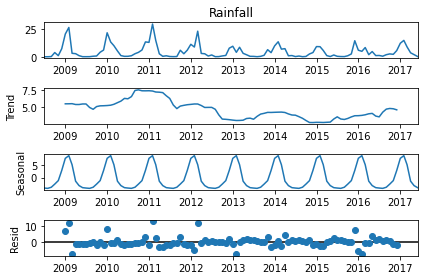

seasonal decompose - tropical - multiplicative


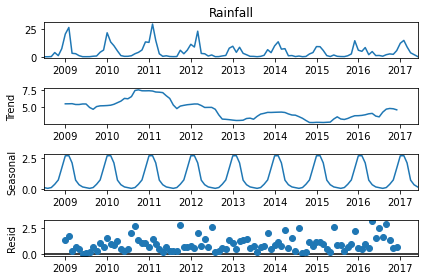

In [322]:
#climat tropical - additive
print('seasonal decompose - tropical - additive')
res_trop = seasonal_decompose(ser_trop, period=12)
res_trop.plot()
plt.show();

#climat tropical - multiplicative
print('seasonal decompose - tropical - multiplicative')
res_trop_mult = seasonal_decompose(ser_trop, period=12, model='multiplicative')
res_trop_mult.plot()
plt.show();

seasonal decompose - méditerranéen - additive


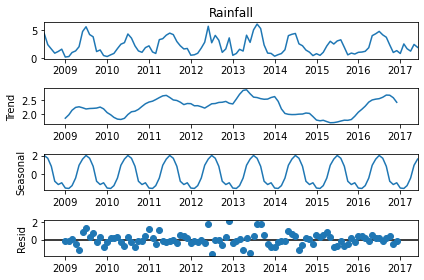

seasonal decompose - méditerranéen - multiplicative


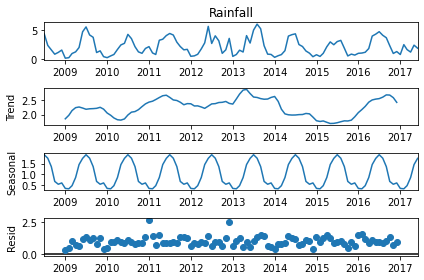

In [323]:
#climat méditerranéen - additive
print('seasonal decompose - méditerranéen - additive')
res_med = seasonal_decompose(ser_med, period=12)
res_med.plot()
plt.show();

#climat méditerranéen - multiplicative
print('seasonal decompose - méditerranéen - multiplicative')
res_med_mult = seasonal_decompose(ser_med, period=12, model='multiplicative')
res_med_mult.plot()
plt.show();

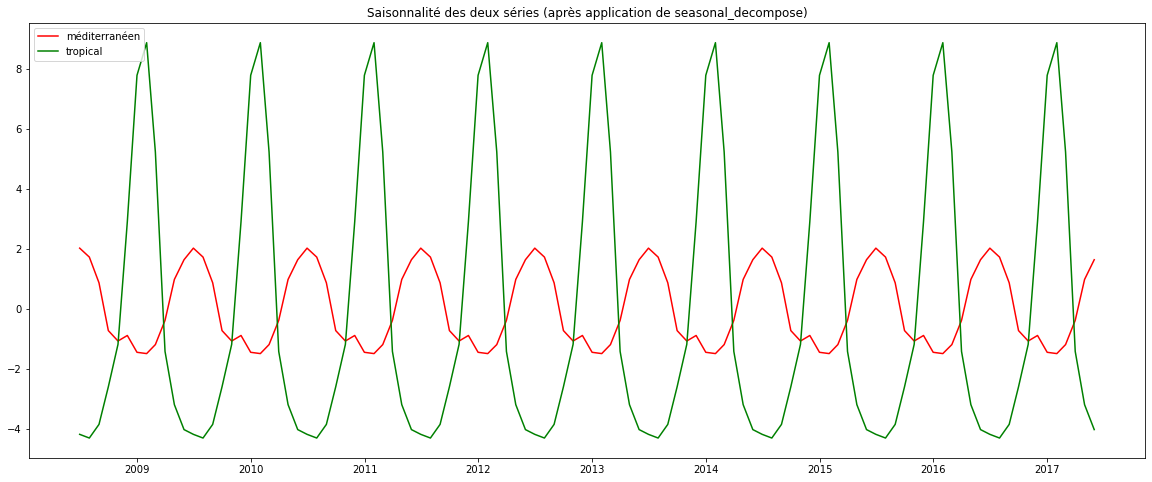

In [324]:
#Visualisation de la saisonnalité des deux séries
plt.figure(figsize=(20,8))
plt.plot(res_med.seasonal, color='red', label='méditerranéen')
plt.plot(res_trop.seasonal, color='green', label='tropical')
plt.title("Saisonnalité des deux séries (après application de seasonal_decompose)")
plt.legend();

Conclusion des visualisations :

Les graphiques confirment notre hypothèse : les deux séries possèdent une forte saisonnalité mais avec un décalage d'une demi-période environ.

La moyenne mobile, calculée sur 12 mois, évolue peu, mais les séries ne sont pas complètement stationnaires. Le climat tropical présente notamment une diminution des pics de précipitations entre 2012 et 2013.

## Modélisation

### Préparation des séries temporelles

In [325]:
#transformée en log
ser_trop_log = np.log(ser_trop)
ser_med_log = np.log(ser_med)

In [326]:
#Réduction du jeu de données d'entrainement : suppression des 24 derniers mois qui serviront de test
ser_trop_red = ser_trop[0:len(ser_trop)-24]
ser_trop_log_red = ser_trop_log[0:len(ser_trop_log)-24]

ser_med_red = ser_med[0:len(ser_med)-24]
ser_med_log_red = ser_med_log[0:len(ser_med_log)-24]

<hr>
<h3> 2.1 - Série climat tropical (Aw+Am) </h3>
<hr>

#### Modélisation SARIMA

In [327]:
#séries non transformées
ser_trop_1 = ser_trop_red.diff().dropna()
ser_trop_2 = ser_trop_1.diff(periods = 12).dropna()

#transformées log
ser_trop_log_1 = ser_trop_log_red.diff().dropna()
ser_trop_log_2 = ser_trop_log_1.diff(periods = 12).dropna()

##### sans transformée log

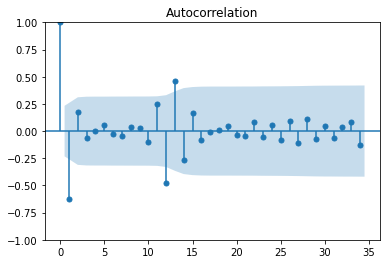

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


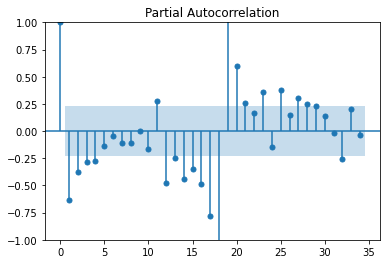

In [328]:
plot_acf(ser_trop_2, lags=34)
plt.show();

plot_pacf(ser_trop_2, lags=34)
plt.show();

In [329]:
step_wise=auto_arima(ser_trop_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=0, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=0,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=1000)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=550.406, Time=1.83 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=508.607, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=521.666, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=587.639, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=522.747, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=502.585, Time=0.52 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=504.157, Time=0.68 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=503.968, Time=0.42 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=502.025, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=517.780, Time=0.12 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=503.994, Time=0.47 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=510.082, Time=0.19 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=505.873, Time=0.53 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=500.960, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[12] intercep

In [330]:
sarima = sm.tsa.SARIMAX(ser_trop_red, order=(0,0,0), seasonal_order=(1,0,1,12))
sarima_fitted = sarima.fit()
print(sarima_fitted.summary())

                                 SARIMAX Results                                  
Dep. Variable:                   Rainfall   No. Observations:                   84
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -250.023
Date:                    Thu, 26 May 2022   AIC                            506.046
Time:                            17:59:21   BIC                            513.339
Sample:                        06-30-2008   HQIC                           508.978
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9508      0.017     55.486      0.000       0.917       0.984
ma.S.L12      -0.4763      0.082     -5.782      0.000      -0.638      -0.315
sigma2        18.464

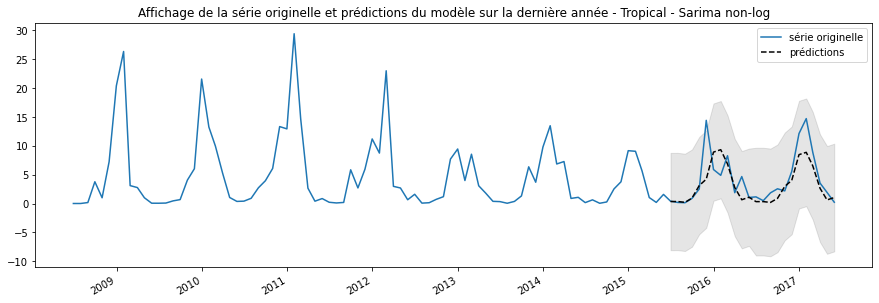

In [331]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
#prediction = np.exp(prediction) #Passage à l'exponentielle

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(ser_trop, label='série originelle')

prediction['mean'].plot(ax = ax, style = 'k--', label='prédictions') #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); #Visualisation de l'intervalle de confiance

plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - Tropical - Sarima non-log")
plt.legend();

In [332]:
#calcul des erreurs du modèle
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(ser_trop.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', 'Rainfall':'réalité'})

dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité))

In [333]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE/(dfcomp.réalité.max() - dfcomp.réalité.min())
NRMSE_moy = RMSE/dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions)/dfcomp.réalité).sum()/len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE =", RMSE)
print("NRMSE min max =", NRMSE_min_max)
print("NRMSE moy =", NRMSE_moy)

print("MAE =", MAE, "+/-", dfcomp.erreur.std())
print("MAPE =", 100*MAPE," %")
print("WMAPE =", 100*WMAPE," %")

RMSE = 3.008009225741648
NRMSE min max = 0.20654168877451135
NRMSE moy = 0.7187748161355207
MAE = 1.9349446844799318 +/- 2.352598985429347
MAPE = 59.12109622819375  %
WMAPE = 46.23621157533372  %


In [334]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.760554
prédictions  0.760554     1.000000

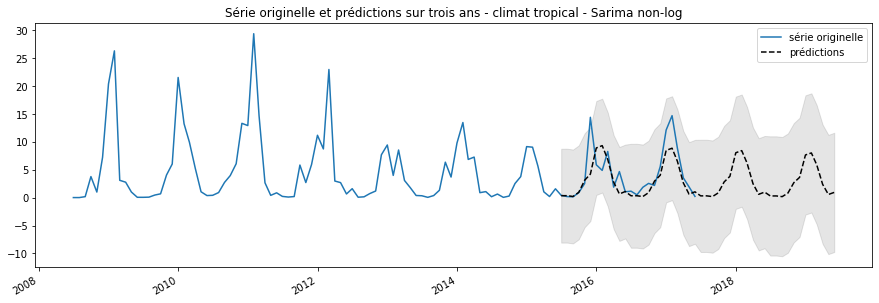

In [335]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(ser_trop, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance
plt.legend()
plt.title("Série originelle et prédictions sur trois ans - climat tropical - Sarima non-log");

##### avec transformée log

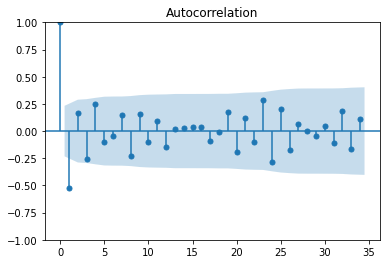

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


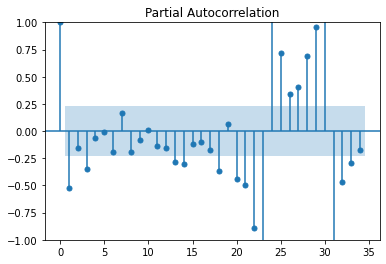

In [336]:
plot_acf(ser_trop_log_2, lags=34)
plt.show();

plot_pacf(ser_trop_log_2, lags=34)
plt.show();

In [337]:
step_wise=auto_arima(ser_trop_log_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=0, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=1,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True,
                     random_state=1001)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=232.429, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=229.686, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=227.130, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=230.503, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=231.553, Time=0.09 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=227.834, Time=0.29 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=226.662, Time=0.33 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=227.494, Time=0.40 sec
 ARIMA(0,0,1)(0,1,3)[12] intercept   : AIC=226.463, Time=0.55 sec
 ARIMA(0,0,1)(1,1,3)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,1)(0,1,4)[12] intercept   : AIC=228.043, Time=0.95 sec
 ARIMA(0,0,1)(1,1,4)[12] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(0,0,0)(0,1,3)[12] intercept   : AIC=230.004, Time=0.45 sec
 ARIMA(1,0,1)(0,1,3)[12] intercept   : AIC=225.216, Time=0.74 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AI

In [344]:
sarima = sm.tsa.SARIMAX(ser_trop_log_red, order=(1,0,0), seasonal_order=(0,1,1,12))
sarima_fitted = sarima.fit()
print(sarima_fitted.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             Rainfall   No. Observations:                   84
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -108.904
Date:                              Thu, 26 May 2022   AIC                            223.808
Time:                                      18:02:06   BIC                            230.638
Sample:                                  06-30-2008   HQIC                           226.527
                                       - 05-31-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2672      0.088      3.024      0.002       0.094       0.440
ma.S.L12      -0.53

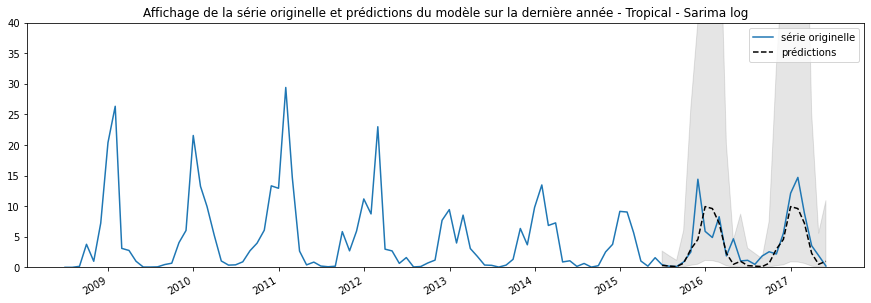

In [345]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
prediction = np.exp(prediction) #Passage à l'exponentielle

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(ser_trop, label='série originelle')

prediction['mean'].plot(ax = ax, style = 'k--', label='prédictions') #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); #Visualisation de l'intervalle de confiance

plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - Tropical - Sarima log")
plt.ylim([0,40])
plt.legend();

In [346]:
#calcul des erreurs du modèle
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(ser_trop.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', 'Rainfall':'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)

In [347]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE/(dfcomp.réalité.max() - dfcomp.réalité.min())
NRMSE_moy = RMSE/dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions)/dfcomp.réalité).sum()/len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE =", RMSE)
print("NRMSE min max =", NRMSE_min_max)
print("NRMSE moy =", NRMSE_moy)

print("MAE =", MAE, "+/-", dfcomp.erreur.std())
print("MAPE =", 100*MAPE," %")
print("WMAPE =", 100*WMAPE," %")

RMSE = 2.8917759213349856
NRMSE min max = 0.19856065508001702
NRMSE moy = 0.69100044254359
MAE = 1.8319875391581304 +/- 2.285574337999203
MAPE = 55.04311745246952  %
WMAPE = 43.776012897576344  %


In [348]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.775499
prédictions  0.775499     1.000000

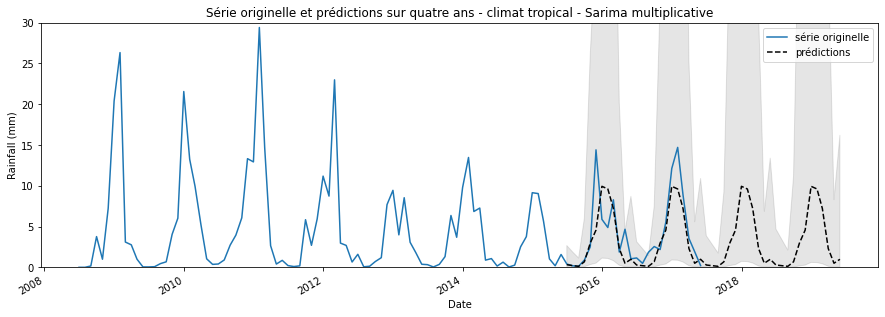

In [349]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(ser_trop, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance

plt.legend()
plt.title("Série originelle et prédictions sur quatre ans - climat tropical - Sarima multiplicative")
plt.ylim([0,30])
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)");

#### Modélisation Prophet

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [350]:
df_prophet=pd.DataFrame({'ds':ser_trop_red.index,'y':ser_trop_red})
df_prophet.info()

# definition du modèle
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_prophet) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2008-06-30 to 2015-05-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      84 non-null     datetime64[ns]
 1   y       84 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


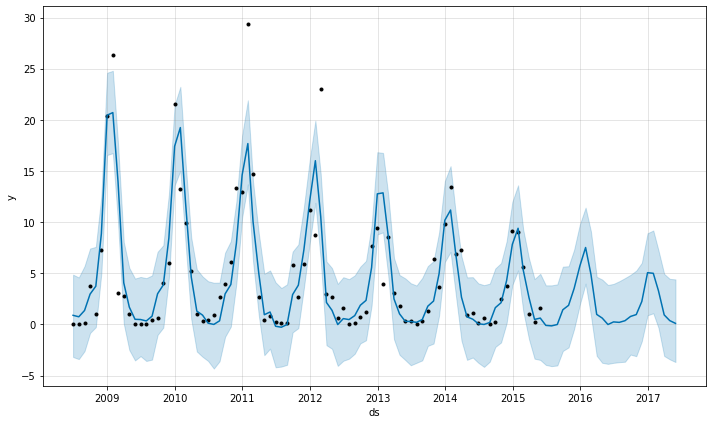

In [351]:
future = model.make_future_dataframe(periods=24,freq = 'M')
#future.head()

forecast = model.predict(future)
forecast.index = forecast["ds"]
forecast.index = pd.to_datetime(forecast.index)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast)

C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


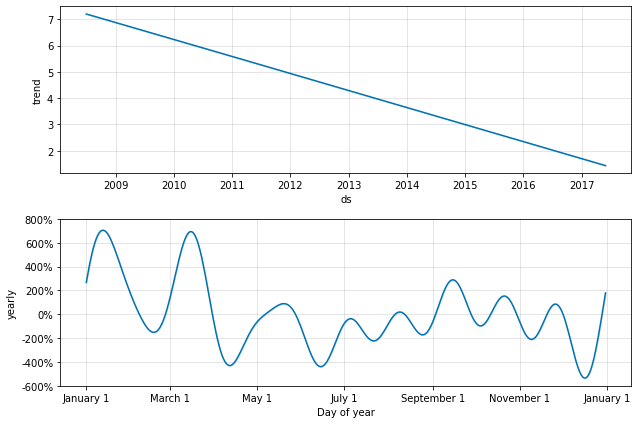

In [352]:
fig = model.plot_components(forecast)

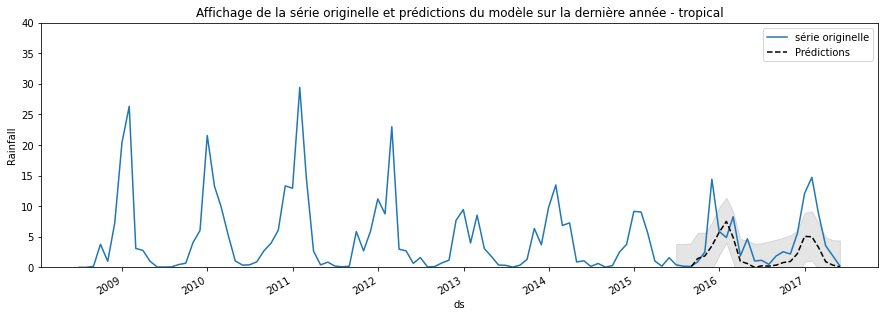

In [353]:
predictions = forecast.tail(24)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(ser_trop, label = "série originelle")
plt.ylim(0,40)
predictions['yhat'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(predictions.index, predictions['yhat_lower'], predictions['yhat_upper'], color='k', alpha=0.1)

Indicateur = "Rainfall"

plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+"tropical")
plt.legend();

In [354]:
dfcomp = forecast.tail(24)
dfcomp.index = ser_trop.tail(24).index
dfcomp = dfcomp.join(ser_trop.tail(24))
dfcomp = dfcomp.rename(columns={'yhat':'prédictions', 'Rainfall':'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)

In [355]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  3.869
NRMSE_min_max :  0.266
NRMSE_moy :  0.925
MAE erreur absolue moyenne :  2.535  +/-  2.9856881370830948
MAPE % erreur absolue moyen :  70.031  %
WMAPE :  60.575  %


In [356]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.729816
prédictions  0.729816     1.000000

<hr>
<h3> 2.2 - Série climat méditerranéen (Csa+Csb) </h3>
<hr>

#### Modélisation SARIMA

In [357]:
#séries non transformées
ser_med_1 = ser_med_red.diff().dropna()
ser_med_2 = ser_med_1.diff(periods = 12).dropna()

#transformées log
ser_med_log_1 = ser_med_log_red.diff().dropna()
ser_med_log_2 = ser_med_log_1.diff(periods = 12).dropna()

##### sans transformée log

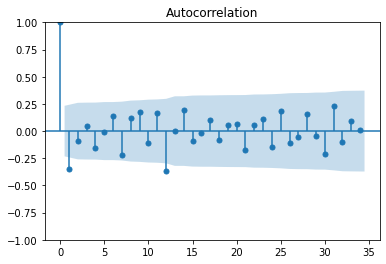

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


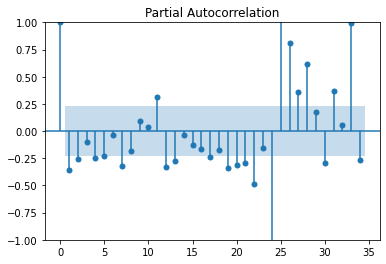

In [358]:
plot_acf(ser_med_2, lags=34)
plt.show();

plot_pacf(ser_med_2, lags=34)
plt.show();

In [359]:
step_wise=auto_arima(ser_med_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=0, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=1,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=240.519, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=217.649, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=238.521, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=235.979, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=214.605, Time=0.21 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=209.484, Time=0.52 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=211.218, Time=1.02 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=209.527, Time=0.35 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=211.484, Time=0.57 sec
 ARIMA(1,0,1)(3,1,0)[12] intercept   : AIC=211.483, Time=0.80 sec
 ARIMA(0,0,1)(3,1,0)[12] intercept   : AIC=209.49

In [360]:
sarima = sm.tsa.SARIMAX(ser_med_red, order=(0,0,0), seasonal_order=(3,1,0,12))
sarima_fitted = sarima.fit()
print(sarima_fitted.summary())

                                SARIMAX Results                                 
Dep. Variable:                 Rainfall   No. Observations:                   84
Model:             SARIMAX(3, 1, 0, 12)   Log Likelihood                -100.113
Date:                  Thu, 26 May 2022   AIC                            208.227
Time:                          18:06:11   BIC                            217.333
Sample:                      06-30-2008   HQIC                           211.852
                           - 05-31-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8358      0.116     -7.180      0.000      -1.064      -0.608
ar.S.L24      -0.5522      0.156     -3.544      0.000      -0.858      -0.247
ar.S.L36      -0.4068      0.177    

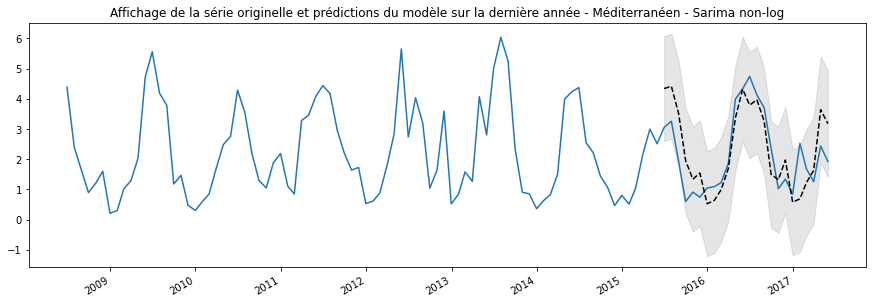

In [361]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
#prediction = np.exp(prediction) #Passage à l'exponentielle

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(ser_med)

prediction['mean'].plot(ax = ax, style = 'k--') #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance

plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - Méditerranéen - Sarima non-log");

In [362]:
#calcul des erreurs du modèle
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(ser_med.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', 'Rainfall':'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)

In [363]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE/(dfcomp.réalité.max() - dfcomp.réalité.min())
NRMSE_moy = RMSE/dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions)/dfcomp.réalité).sum()/len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE =", RMSE)
print("NRMSE min max =", NRMSE_min_max)
print("NRMSE moy =", NRMSE_moy)

print("MAE =", MAE, "+/-", dfcomp.erreur.std())
print("MAPE =", 100*MAPE," %")
print("WMAPE =", 100*WMAPE," %")

RMSE = 0.8723430568264463
NRMSE min max = 0.21061242026183674
NRMSE moy = 0.40282328575132975
MAE = 0.7226024786749381 +/- 0.49921127349952743
MAPE = 45.839166713710824  %
WMAPE = 33.36773331019985  %


In [364]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.778148
prédictions  0.778148     1.000000

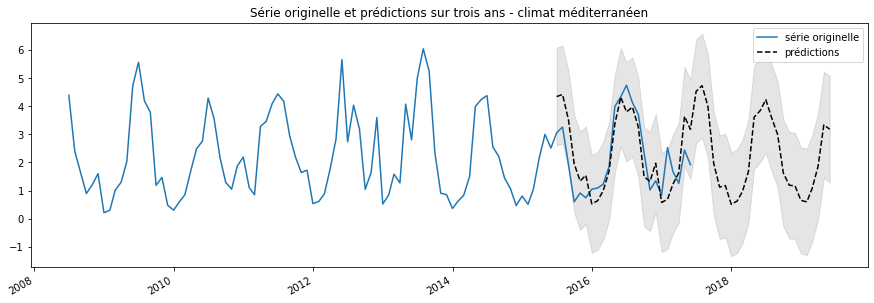

In [365]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(ser_med, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance
plt.legend()
plt.title("Série originelle et prédictions sur trois ans - climat méditerranéen");

##### avec transformée log

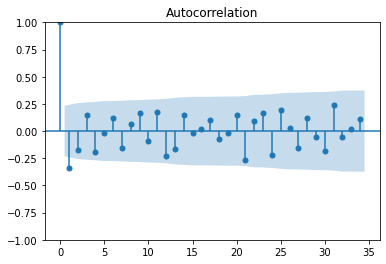

C:\Users\lione\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


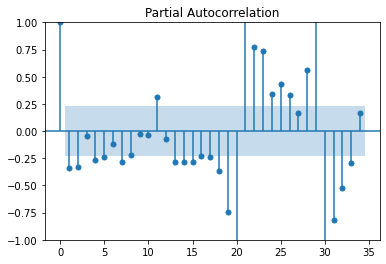

In [366]:
plot_acf(ser_med_log_2, lags=34)
plt.show();

plot_pacf(ser_med_log_2, lags=34)
plt.show();

In [367]:
step_wise=auto_arima(ser_med_log_red, 
                     start_p=0,
                     max_p=7,
                     start_q=0, 
                     max_q=7, 
                     d=0, 
                     max_d=7,
                     start_P=0,
                     max_P=7,
                     start_Q=0,
                     max_Q=7,
                     D=1,
                     max_D=7,
                     m=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=132.420, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=120.914, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=130.528, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=128.716, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=117.465, Time=0.31 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=106.537, Time=0.75 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=104.498, Time=0.97 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=106.171, Time=2.37 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=106.201, Time=2.25 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=104.418, Time=1.09 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,0,0)(3,1,2)[12] intercept   : AIC=106.124, Time=2.04 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,0)(4,1,2)[12] intercept   : AIC=10

In [368]:
sarima = sm.tsa.SARIMAX(ser_med_log_red, order=(1,0,0), seasonal_order=(3,1,0,12))
sarima_fitted = sarima.fit()
print(sarima_fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Rainfall   No. Observations:                   84
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 12)   Log Likelihood                 -47.407
Date:                            Thu, 26 May 2022   AIC                            104.814
Time:                                    18:08:08   BIC                            116.198
Sample:                                06-30-2008   HQIC                           109.346
                                     - 05-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3306      0.137      2.418      0.016       0.063       0.599
ar.S.L12      -0.7121      0.125   

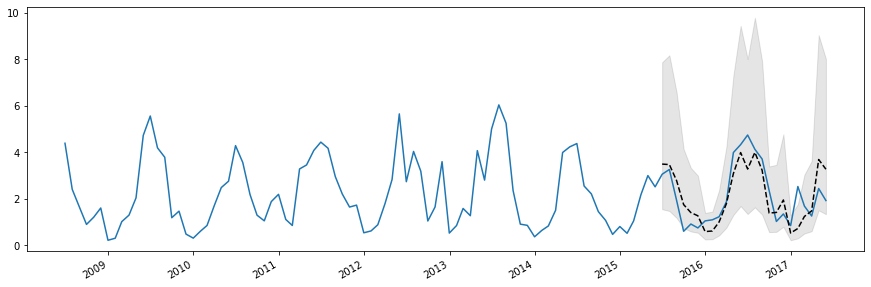

In [369]:
prediction = sarima_fitted.get_forecast(steps =24).summary_frame()  #Prédiction avec intervalle de confiance
prediction = np.exp(prediction) #Passage à l'exponentielle

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(ser_med)

prediction['mean'].plot(ax = ax, style = 'k--') #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); #Visualisation de l'intervalle de confiance

In [370]:
#calcul des erreurs du modèle
dfcomp = prediction.iloc[:,0:1]
dfcomp = dfcomp.join(ser_med.tail(24))
dfcomp = dfcomp.rename(columns={'mean':'prédictions', 'Rainfall':'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)

In [371]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE/(dfcomp.réalité.max() - dfcomp.réalité.min())
NRMSE_moy = RMSE/dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions)/dfcomp.réalité).sum()/len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE =", RMSE)
print("NRMSE min max =", NRMSE_min_max)
print("NRMSE moy =", NRMSE_moy)

print("MAE =", MAE, "+/-", dfcomp.erreur.std())
print("MAPE =", 100*MAPE," %")
print("WMAPE =", 100*WMAPE," %")

RMSE = 0.7920741566472758
NRMSE min max = 0.19123285713446692
NRMSE moy = 0.3657573839128379
MAE = 0.6490113084845347 +/- 0.4638205699782793
MAPE = 40.35248349623991  %
WMAPE = 29.9695017605354  %


In [284]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.809732
prédictions  0.809732     1.000000

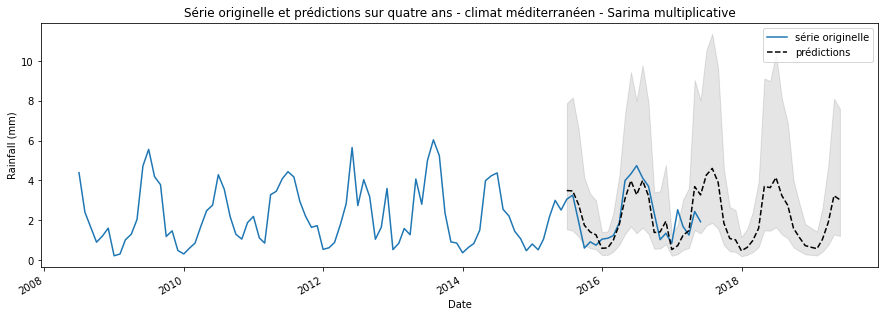

In [372]:
#Prédictions futures sur trois ans"
prediction = sarima_fitted.get_forecast(steps = 48).summary_frame()  
prediction = np.exp(prediction)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(ser_med, label="série originelle")
prediction['mean'].plot(ax = ax, style = 'k--', label="prédictions"); #Visualisation de la moyenne
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1) #Visualisation de l'intervalle de confiance

plt.legend()
plt.title("Série originelle et prédictions sur quatre ans - climat méditerranéen - Sarima multiplicative")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)");

#### Modélisation Prophet

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [373]:
df_prophet=pd.DataFrame({'ds':ser_med_red.index,'y':ser_med_red})
df_prophet.info()

# definition du modèle
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_prophet) 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2008-06-30 to 2015-05-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      84 non-null     datetime64[ns]
 1   y       84 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


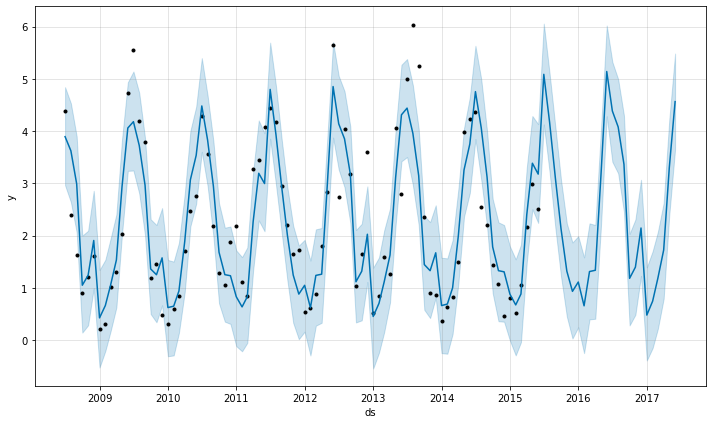

In [374]:
future = model.make_future_dataframe(periods=24,freq = 'M')
#future.head()

forecast = model.predict(future)
forecast.index = forecast["ds"]
forecast.index = pd.to_datetime(forecast.index)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast)


C:\Utilitaires\Anaconda3\envs\time_series\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


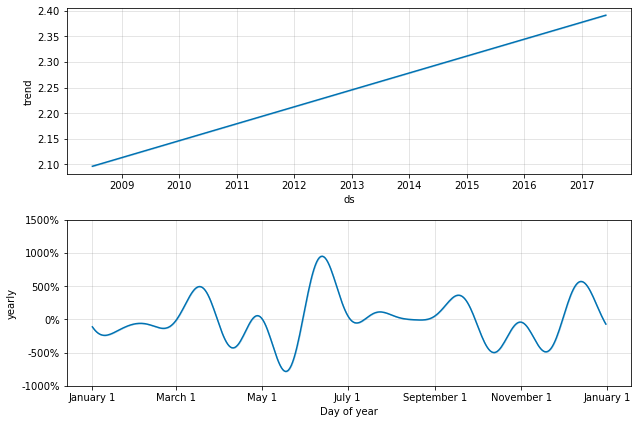

In [375]:
fig = model.plot_components(forecast)

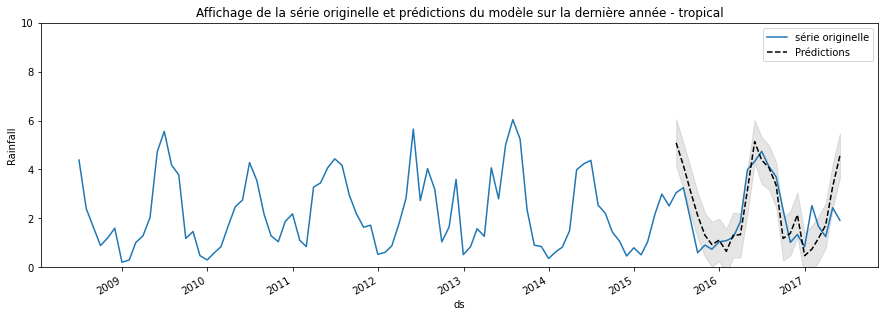

In [376]:
predictions = forecast.tail(24)

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(ser_med, label = "série originelle")
plt.ylim(0,10)
predictions['yhat'].plot(ax = ax, style = 'k--', label = "Prédictions") #Visualisation de la moyenne
ax.fill_between(predictions.index, predictions['yhat_lower'], predictions['yhat_upper'], color='k', alpha=0.1)

Indicateur = "Rainfall"

plt.ylabel(Indicateur)
plt.title("Affichage de la série originelle et prédictions du modèle sur la dernière année - "+"tropical")
plt.legend();

In [377]:
dfcomp = forecast.tail(24)
dfcomp.index = ser_med.tail(24).index
dfcomp = dfcomp.join(ser_med.tail(24))
dfcomp = dfcomp.rename(columns={'yhat':'prédictions', 'Rainfall':'réalité'})
dfcomp["erreur"] = np.abs(dfcomp.prédictions - dfcomp.réalité)
dfcomp["% erreur"] = 100*(np.abs(dfcomp.prédictions - dfcomp.réalité)/dfcomp.réalité)

In [378]:
RMSE = np.sqrt(mean_squared_error(dfcomp.réalité, dfcomp.prédictions))
NRMSE_min_max = RMSE / (dfcomp.réalité.max() - dfcomp.réalité.min() )
NRMSE_moy = RMSE / dfcomp.réalité.mean()

MAE = mean_absolute_error(dfcomp.réalité, dfcomp.prédictions)
MAPE = np.abs((dfcomp.réalité - dfcomp.prédictions) / dfcomp.réalité).sum() / len(dfcomp)
WMAPE = np.abs(dfcomp.réalité - dfcomp.prédictions).sum() / np.abs(dfcomp.réalité).sum()

print("RMSE erreur quadratique moyenne : ", RMSE.round(3) )
print("NRMSE_min_max : ", NRMSE_min_max.round(3) )
print("NRMSE_moy : ", NRMSE_moy.round(3) )

print("MAE erreur absolue moyenne : ", MAE.round(3), " +/- ", dfcomp.erreur.std() )
print("MAPE % erreur absolue moyen : ", (100*MAPE).round(3), " %" )
print("WMAPE : ", (100*WMAPE).round(3), " %" )

RMSE erreur quadratique moyenne :  1.013
NRMSE_min_max :  0.245
NRMSE_moy :  0.468
MAE erreur absolue moyenne :  0.78  +/-  0.6601170573230083
MAPE % erreur absolue moyen :  46.688  %
WMAPE :  36.017  %


In [379]:
print("Matrice de corrélation :")
dfcomp[['réalité', 'prédictions']].corr()

Matrice de corrélation :


réalité  prédictions
réalité      1.000000     0.757161
prédictions  0.757161     1.000000

<hr>
<h2> CONCLUSION de la partie 2 : série temporelle Rainfall des deux climats </h2>
<hr>

Les performances sont meilleures sur ces deux climats que sur les villes prises indépendamment, avec des erreurs plus faible et un coefficient de corrélation dépassant les 80 %. 
On remarque aussi de performances légèrement meilleures pour le climat méditerranéen que pour le climat tropical, si l’on considère l’erreur WMAPE. Cette différence peut s’interpréter par une meilleure stationnarité de la série méditerranéenne, visible en observant la courbe de la moyenne mobile.